In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import galsim
import scipy.stats as stats
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator, results_processing

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, delta_min, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import deblender_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Function to import deblender

In [3]:
deblender_lsst,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v8/mse/', #7/bis
                                                                                     6, folder = True)#6/train_6  #7 (PReLu pas sur echantillons 28)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v7/mse/',#6/bis_bis
                                                                                            10, folder = True)#5/train_7  #6 (PReLu pas sur echantillons 28)

# Fix parameters

In [5]:
# Batch size for training
batch_size = 100

# Physical stamp size
phys_stamp_size_euclid = 6.4 # arcsec for VIS Euclid instrument
phys_stamp_size_lsst = 3.2 # arcsec for LSST instrument

# Pixel scales
pixel_scale_euclid_vis = 0.1 # arcsec/pixel
pixel_scale_lsst = 0.2

# Stamp size used
stamp_size = int(phys_stamp_size_euclid/pixel_scale_euclid_vis)

# Load test data

Load shifts and images

In [6]:
data_dir = '/sps/lsst/users/barcelin/data/blended_images/28/test/'
root = 'galaxies_blended_20191024'

In [7]:
#data_dir = '/sps/lsst/users/barcelin/data/blended_images/28/test/'
#root = 'galaxies_blended_20191022'

In [8]:
shifts = np.load(os.path.join(data_dir, root+'_0_shifts.npy'))

In [9]:
images = np.load(data_dir+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
#images = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_v5.npy', mmap_mode = 'c')

Load rest of test data

In [10]:
dfs = []

#dfs.append(pd.read_csv(os.path.join(data_dir, root+'_010_data.csv')))
dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null float64
closest_mag_ir                10000 non-null f

In [12]:
df.head()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_aperture_lsst,blendedness_total_euclid,blendedness_closest_lsst,blendedness_closest_euclid
0,1,15.781470,0.025592,0.7098,1.829501,0.223382,0.655042,27.540166,-0.727031,0.000000,...,1.829501,0.223382,0.655042,27.540166,-0.727031,NaN,NaN,NaN,NaN,NaN
1,2,20.708087,0.033953,0.9105,1.792517,0.105859,-0.378878,27.304975,-1.418065,-0.231124,...,1.845979,-0.005509,-0.022913,27.804054,-1.741781,0.346432,0.386406,0.394027,0.862332,0.436364
2,3,31.953924,0.051536,0.1093,1.806190,-0.014020,-0.023056,26.840205,0.148202,0.209490,...,2.276119,0.009499,0.246913,27.850809,-0.822674,0.353853,0.436291,0.693789,0.873790,0.656476
3,1,53.787724,0.092461,2.0544,1.704342,-0.349515,0.255104,26.325956,-1.861323,0.000000,...,1.704342,-0.349515,0.255104,26.325956,-1.861323,NaN,NaN,NaN,NaN,NaN
4,3,41.688855,0.051362,0.6970,2.587121,-0.385746,-0.156778,26.088455,-1.978798,0.823316,...,1.628176,0.177990,-0.380756,27.901612,-0.339781,0.200921,0.318515,0.125492,0.288838,0.049573


In [13]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_aperture_lsst,blendedness_total_euclid,blendedness_closest_lsst,blendedness_closest_euclid
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,6927.000000,6927.000000,6927.000000,6927.000000,6927.000000
mean,2.326800,120.542613,0.184105,0.923295,2.175666,0.003445,-0.001777,25.974744,-1.951157,-0.002958,...,1.953143,-0.004213,-0.005069,26.998331,-1.251281,0.225986,0.359323,0.155983,0.539313,0.269388
std,1.111002,237.650885,0.428907,0.733529,0.533526,0.278100,0.278661,1.404586,1.374391,0.404644,...,0.371246,0.292470,0.297245,0.929195,1.240879,0.145028,0.179466,0.160187,0.232039,0.234183
min,1.000000,6.343976,0.006464,0.006500,1.488476,-1.564115,-1.397318,20.037094,-7.306114,-0.999368,...,1.492670,-1.576889,-1.358944,20.448996,-6.996996,0.001561,0.001576,0.000145,0.023587,0.000245
25%,1.000000,25.346898,0.038478,0.405900,1.804618,-0.156923,-0.157973,25.240076,-2.837569,-0.202946,...,1.697775,-0.188777,-0.191581,26.671884,-1.904178,0.104868,0.221880,0.033467,0.345620,0.072935
50%,2.000000,45.650881,0.067025,0.718750,2.042732,0.001054,0.002363,26.283262,-1.765570,0.000000,...,1.852790,-0.004441,-0.005185,27.251823,-1.030067,0.205507,0.379510,0.100183,0.542005,0.197978
75%,3.000000,97.979607,0.141105,1.139800,2.394902,0.160726,0.157897,27.013120,-0.958320,0.196136,...,2.093602,0.173691,0.181968,27.630291,-0.371419,0.327835,0.495176,0.228232,0.729688,0.418673
max,4.000000,3050.680684,7.746850,5.208000,5.651824,1.465109,1.434683,27.996072,0.946252,0.999947,...,5.232187,1.991984,1.614200,27.999770,0.946252,0.764361,0.763329,0.916789,0.997504,0.988586


27.996071897478828

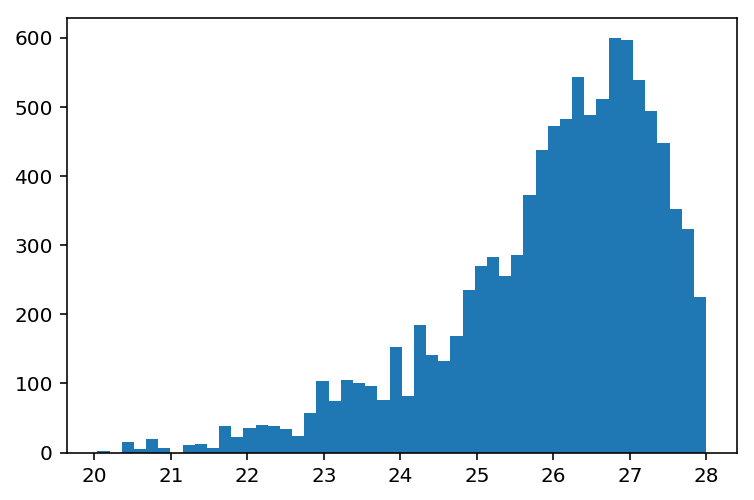

In [14]:
_ = plt.hist(df['mag'], bins = 50)
np.max(df['mag'])

# Batch Generation

In [11]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [12]:
list_of_samples = [data_dir+'galaxies_blended_20191024_0_images.npy']#'galaxies_blended_20191004_test_010_images.npy']

In [13]:
#list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/galaxies_COSMOS_test_v5.npy']

In [14]:
bands_lsst = [4,5,6,7,8,9]

In [15]:
batch_gen = generator.BatchGenerator(bands_lsst, list_of_samples,total_sample_size=10000, 
                                     batch_size= 100, 
                                     trainval_or_test = 'test', 
                                     do_norm = True, 
                                     denorm = False,
                                     list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [16]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [17]:
batch_gen_lsst_euclid = generator.BatchGenerator(bands_lsst_euclid, list_of_samples,total_sample_size=10000, 
                                                 batch_size= 100, 
                                                 trainval_or_test = 'test', 
                                                 do_norm = True, 
                                                 denorm = False,
                                                 list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


# LSST only

## Shape reproduction

In [18]:
reload(results_processing), reload(generator)

(<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>,
 <module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>)

In [19]:
N = 100
batch_size = 100

ellipticities_lsst,e_beta_lsst, flux_in_lsst, flux_out_lsst, indices_lsst = results_processing.deblender_processing(deblender_lsst, 
                                                                                                                    batch_gen,
                                                                                                                    bands_lsst,
                                                                                                                    2,
                                                                                                                    stamp_size, 
                                                                                                                    N, batch_size)

In [22]:
np.save('data/e1_e2_lsst_4.npy', ellipticities_lsst)
np.save('data/e_beta_lsst_4.npy', e_beta_lsst)
np.save('data/flux_in_lsst_4.npy', flux_in_lsst)
np.save('data/flux_out_lsst_4.npy', flux_out_lsst)
np.save('data/indices_lsst_4.npy', indices_lsst)

In [17]:
ellipticities_lsst = np.load('data/e1_e2_lsst_4.npy')
e_beta_lsst = np.load('data/e_beta_lsst_4.npy')
flux_in_lsst = np.load('data/flux_in_lsst_4.npy')
flux_out_lsst = np.load('data/flux_out_lsst_4.npy')
indices_lsst = np.load('data/indices_lsst_4.npy') #2472, 7537

In [20]:
delta_e1_lsst = ellipticities_lsst[:,1,0] - ellipticities_lsst[:,0,0]
delta_e2_lsst = ellipticities_lsst[:,1,1] - ellipticities_lsst[:,0,1]
delta_e_lsst =  e_beta_lsst[:,1,0] - e_beta_lsst[:,0,0]

In [21]:
delta_mag_lsst = -2.5*np.log10(flux_out_lsst/flux_in_lsst)

In [22]:
mag_in_lsst = -2.5*np.log10(flux_in_lsst)+38.4147
mag_out_lsst = -2.5*np.log10(flux_out_lsst)+38.4147

In [23]:
mag_input = df['mag']

Plots

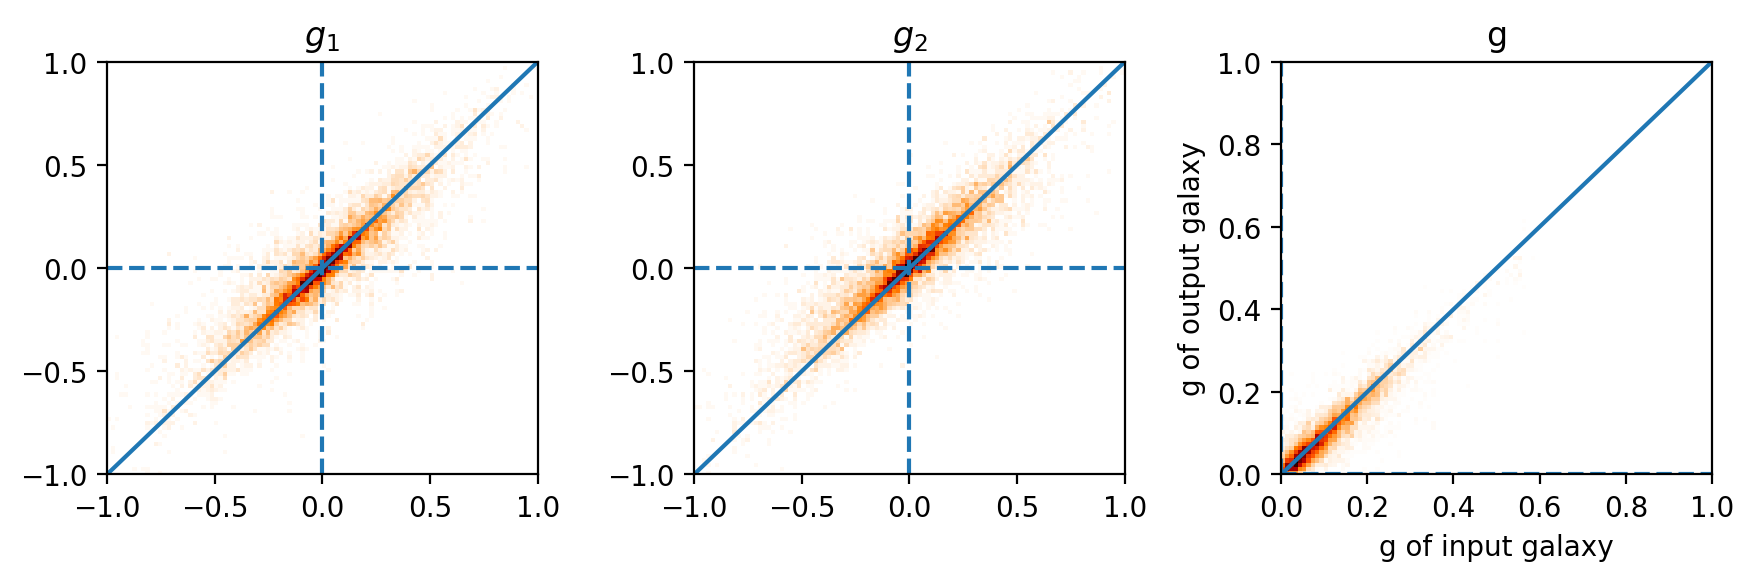

In [23]:
import matplotlib as mpl
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rcdefaults()

fig, axes = plt.subplots(1,3, figsize=(9,3))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst[:,0,i], ellipticities_lsst[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$g_{}$'.format(i+1))#,fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

emax = 1
_ = axes[2].hist2d(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('g'.format(i+1))#,fontsize=24)# color="w", 
axes[2].tick_params(axis='x')#, colors='w'
axes[2].tick_params(axis='y')#, colors='w'
axes[2].set_xlabel('g of input galaxy')
axes[2].set_ylabel('g of output galaxy')

fig.tight_layout()

In [24]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0])

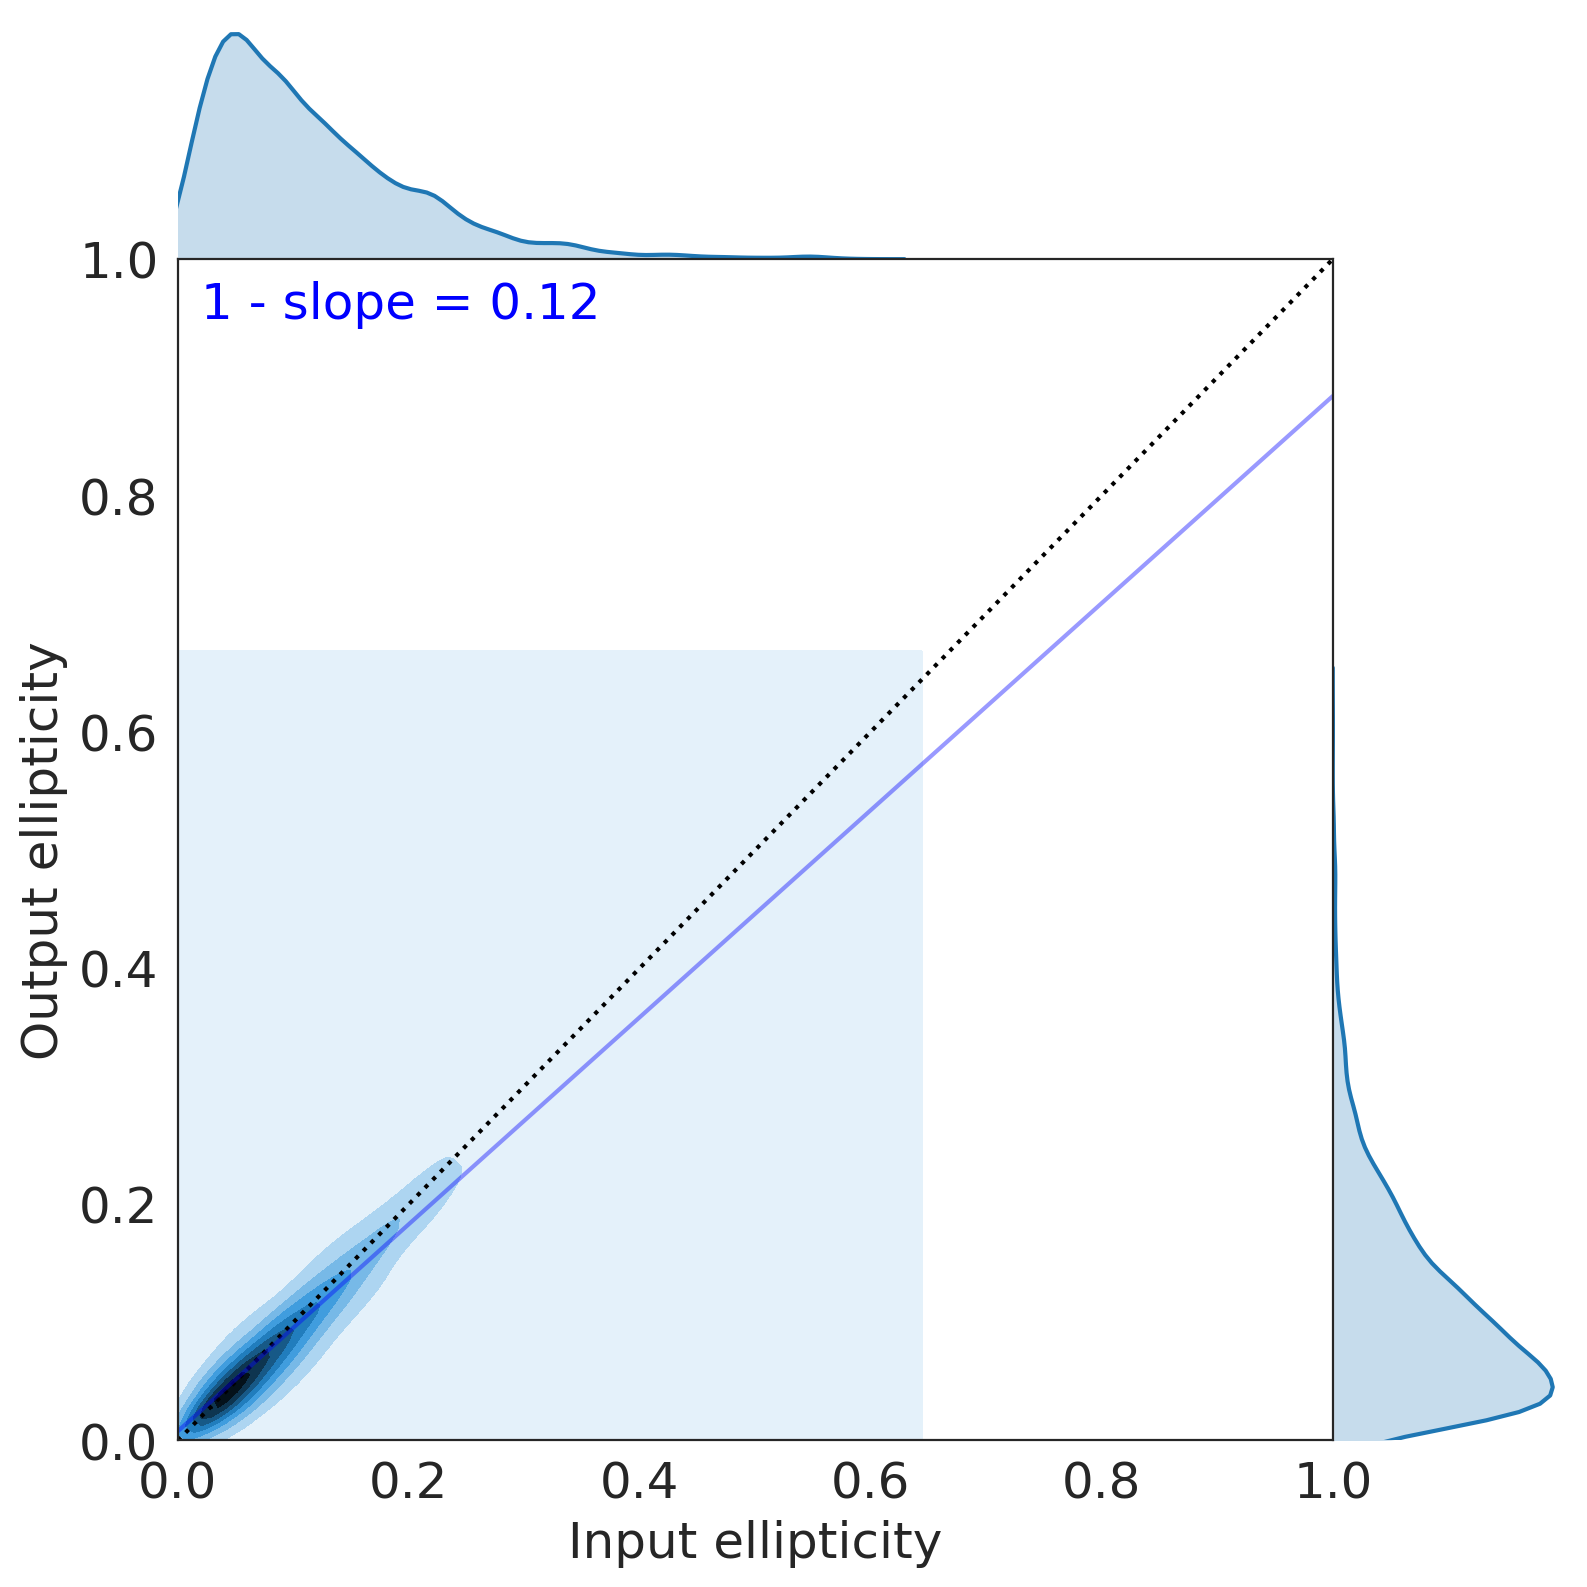

In [25]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
    
            g = sns.jointplot(e_beta_lsst[:,0,0], e_beta_lsst[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst*np.linspace(0, 1)+intercept_lsst, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst, 2)), color='b')

Text(-0.47, 800, 'median of histo = -0.005')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


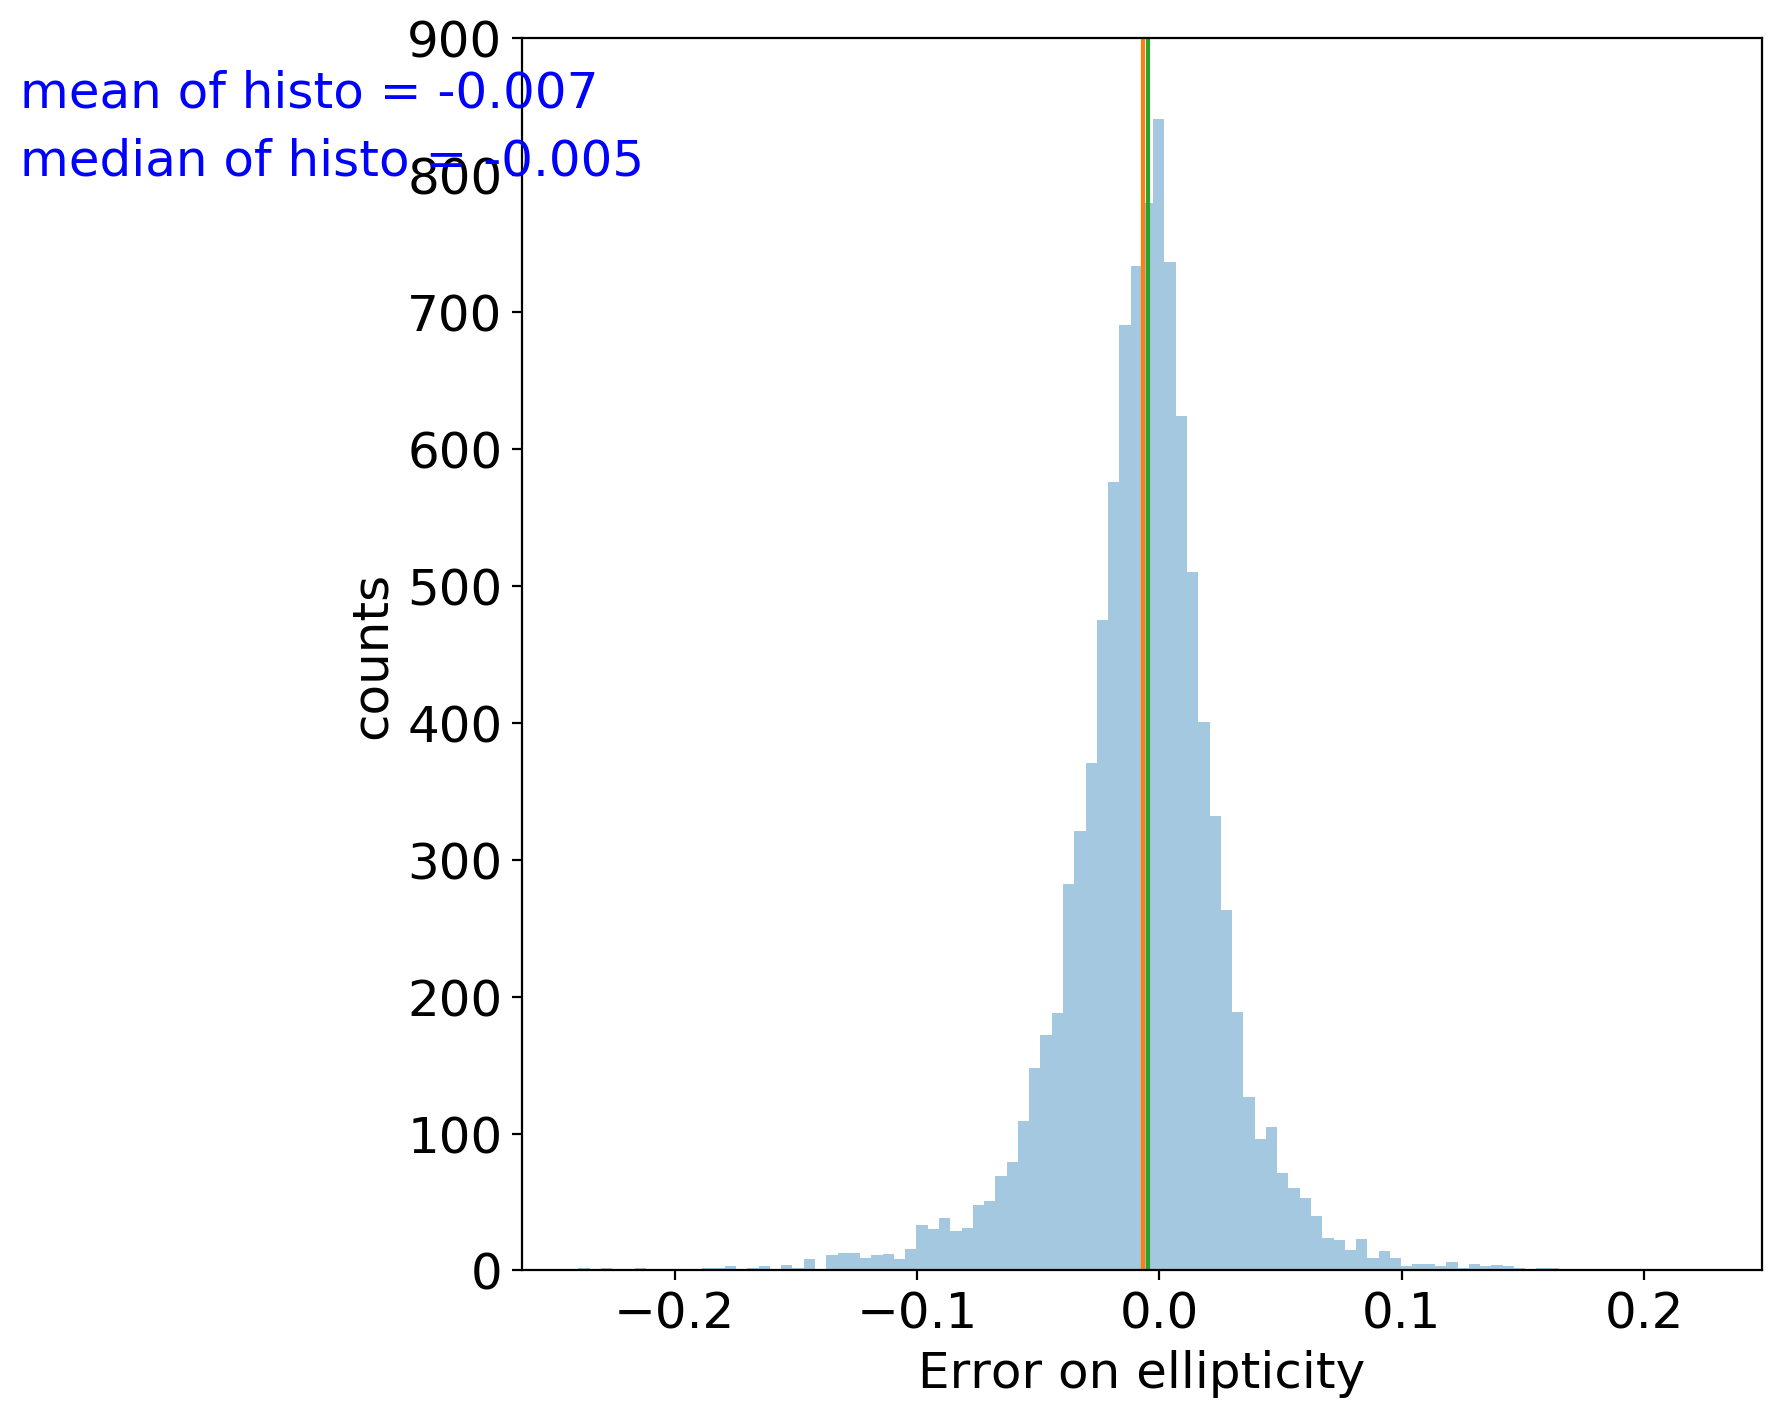

In [26]:
fig, axes = plt.subplots(1,1, figsize=(8,8))

a = sns.distplot(delta_e_lsst, bins = 100, hist = True, kde = False)
a.set_xlabel('Error on ellipticity')
a.set_ylabel('counts')
a.plot(np.ones((50,))*np.mean(delta_e_lsst),np.linspace(0, 1000))
a.plot(np.ones((50,))*np.median(delta_e_lsst),np.linspace(0, 1000))

a.set_ylim(0, 900)
a.text(-0.47, 850, 'mean of histo = '+str(round(np.mean(delta_e_lsst), 3)), color='b')
a.text(-0.47, 800, 'median of histo = '+str(round(np.median(delta_e_lsst), 3)), color='b')

## Flux reproduction

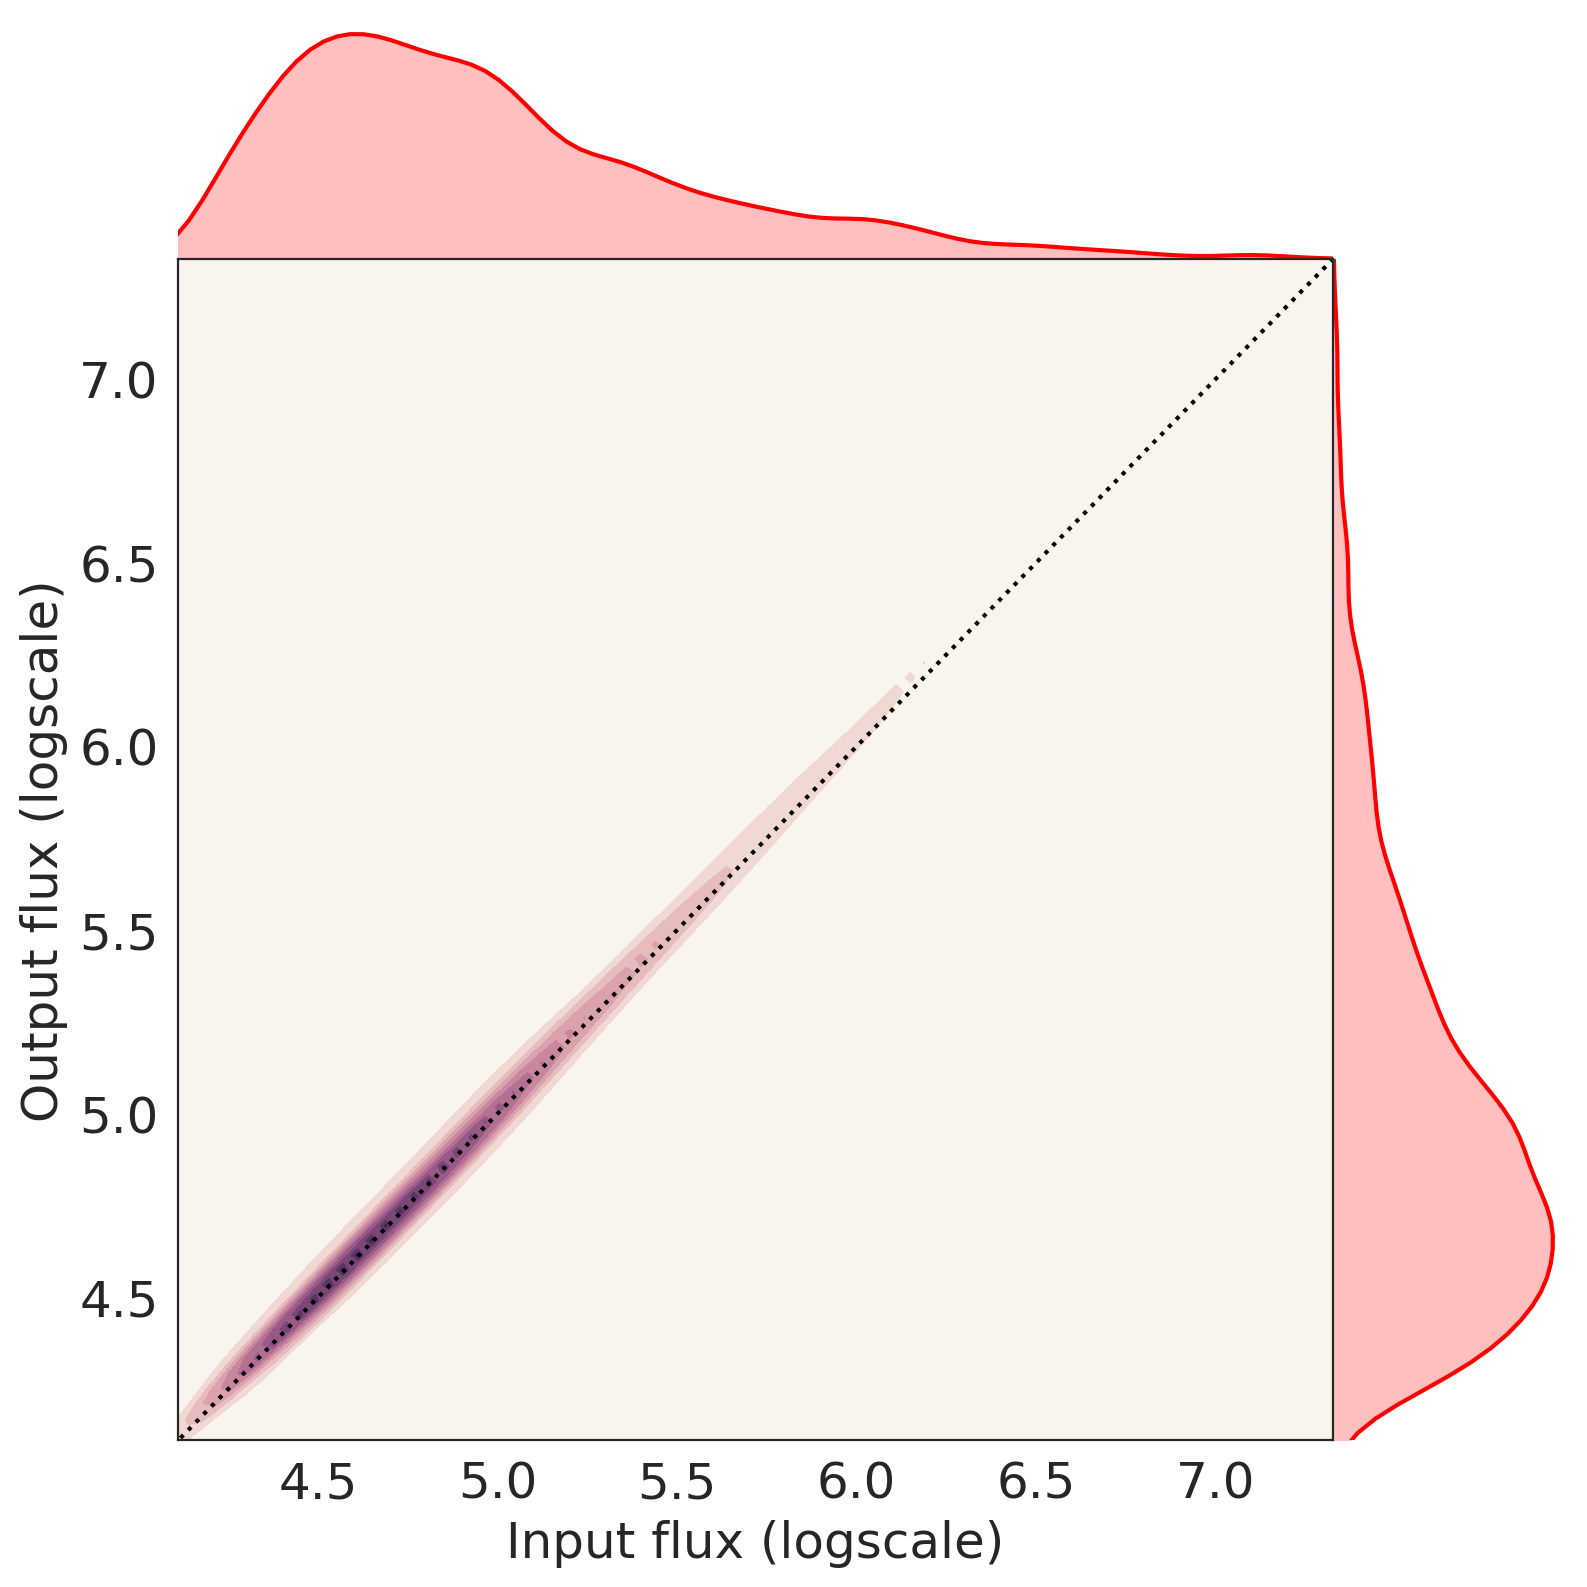

In [27]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst), np.log10(flux_out_lsst), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))], ylim=[np.min(np.log10(flux_in_lsst-1000)), np.max(np.log10(flux_in_lsst))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst))), ':k')

# LSST + Euclid

## Shape reproduction

In [118]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [24]:
N = 100
batch_size = 100 

ellipticities_lsst_euclid,e_beta_lsst_euclid, flux_in_lsst_euclid, flux_out_lsst_euclid, indices_lsst_euclid = results_processing.deblender_processing(deblender_lsst_euclid, batch_gen_lsst_euclid,bands_lsst_euclid,6,stamp_size, N, batch_size)

error for galaxy 7146


In [ ]:
N = 100
batch_size = 100 

ellipticities_lsst_euclid,e_beta_lsst_euclid, flux_in_lsst_euclid, flux_out_lsst_euclid, indices_lsst_euclid = results_processing.deblender_processing(deblender_lsst_euclid, batch_gen_lsst_euclid,bands_lsst_euclid,6,stamp_size, N, batch_size)

In [21]:
np.save('data/e1_e2_lsst_euclid_4.npy', ellipticities_lsst_euclid)
np.save('data/e_beta_lsst_euclid_4.npy', e_beta_lsst_euclid) 
np.save('data/flux_in_lsst_euclid_4.npy', flux_in_lsst_euclid)
np.save('data/flux_out_lsst_euclid_4.npy', flux_out_lsst_euclid)
np.save('data/indices_lsst_euclid_4.npy', indices_lsst_euclid) # 766, 3397, 9067

In [32]:
ellipticities_lsst_euclid = np.load('data/e1_e2_lsst_euclid_2.npy')
e_beta_lsst_euclid = np.load('data/e_beta_lsst_euclid_2.npy')
flux_in_lsst_euclid = np.load('data/flux_in_lsst_euclid_2.npy')
flux_out_lsst_euclid = np.load('data/flux_out_lsst_euclid_2.npy')
indices_lsst_euclid = np.load('data/indices_lsst_euclid_2.npy')

In [34]:
e_beta_lsst_euclid.shape, ellipticities_lsst_euclid.shape

((9997, 2, 2), (9997, 2, 2))

In [25]:
delta_e_lsst_euclid =  e_beta_lsst_euclid[:,1,0] - e_beta_lsst_euclid[:,0,0]
delta_e1_lsst_euclid = ellipticities_lsst_euclid[:,1,0] - ellipticities_lsst_euclid[:,0,0]
delta_e2_lsst_euclid = ellipticities_lsst_euclid[:,1,1] - ellipticities_lsst_euclid[:,0,1]

In [26]:
flux_in_lsst_euclid.shape

(9999,)

In [27]:
delta_mag_lsst_euclid = -2.5*np.log10(flux_out_lsst_euclid/flux_in_lsst_euclid)

In [28]:
mag_in_lsst_euclid = -2.5*np.log10(flux_in_lsst_euclid)+38.4147
mag_out_lsst_euclid = -2.5*np.log10(flux_out_lsst_euclid)+38.4147

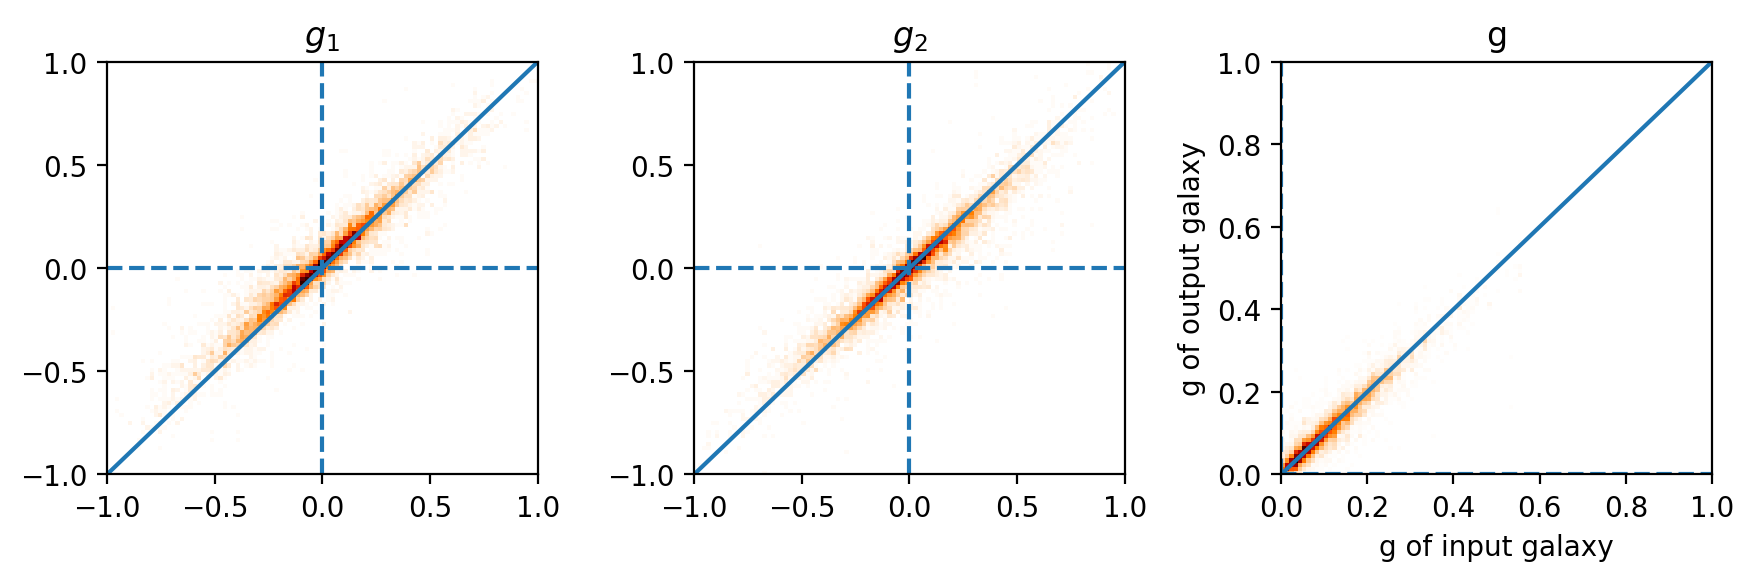

In [29]:
matplotlib.rcdefaults()

fig, axes = plt.subplots(1,3, figsize=(9,3))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_lsst_euclid[:,0,i], ellipticities_lsst_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$g_{}$'.format(i+1))#,fontsize=20)
    axes[i].spines['bottom']
    axes[i].spines['right']
    axes[i].spines['left']
    axes[i].spines['top']
    axes[i].xaxis.label
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')

emax = 1
_ = axes[2].hist2d(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes[2].plot([0,+emax],[0,+emax])
axes[2].axhline(y=0, ls='--')
axes[2].axvline(x=0, ls='--')
axes[2].set_title('g'.format(i+1))#,fontsize=24)#
axes[2].tick_params(axis='x')
axes[2].tick_params(axis='y')
axes[2].set_xlabel('g of input galaxy')
axes[2].set_ylabel('g of output galaxy')

fig.tight_layout()

In [30]:
# Linear regression
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0])

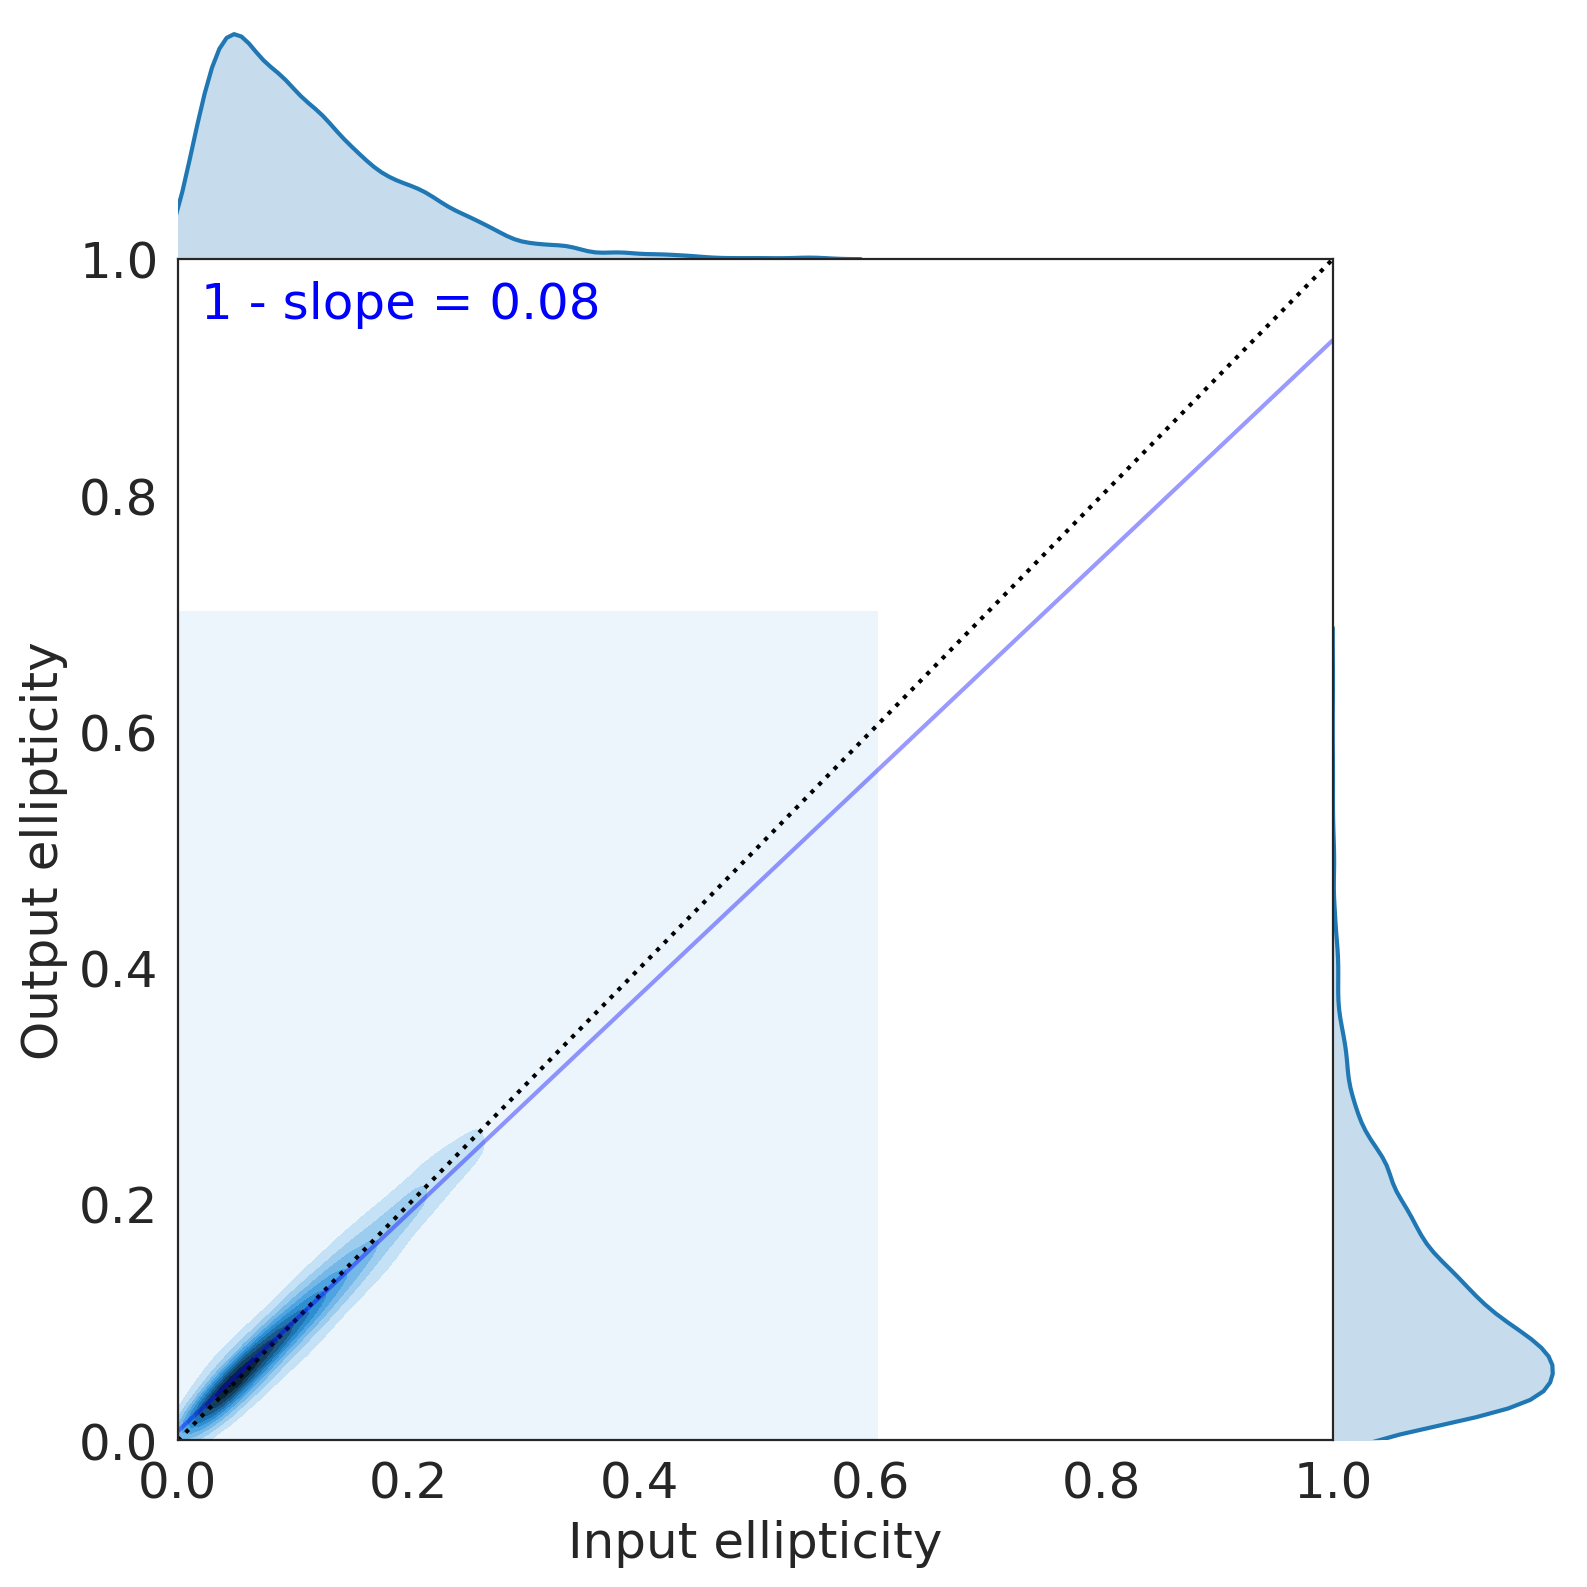

In [31]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

with sns.axes_style('white'):
            
            g = sns.jointplot(e_beta_lsst_euclid[:,0,0], e_beta_lsst_euclid[:,1,0], kind='kde',height =8,
                              xlim =[0, 1], ylim=[0, 1], space=0,joint_kws={'shade_lowest':True}).set_axis_labels('Input ellipticity', 'Output ellipticity')
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')
            g.ax_joint.plot(np.linspace(0, 1),
                            slope_lsst_euclid*np.linspace(0, 1)+intercept_lsst_euclid, color = 'b', alpha = 0.4)
            g.ax_joint.text(0.02, 0.95, '1 - slope = '+str(round(1-slope_lsst_euclid, 2)), color='b')

Text(-0.37, 1100, 'median of histo = -0.0')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


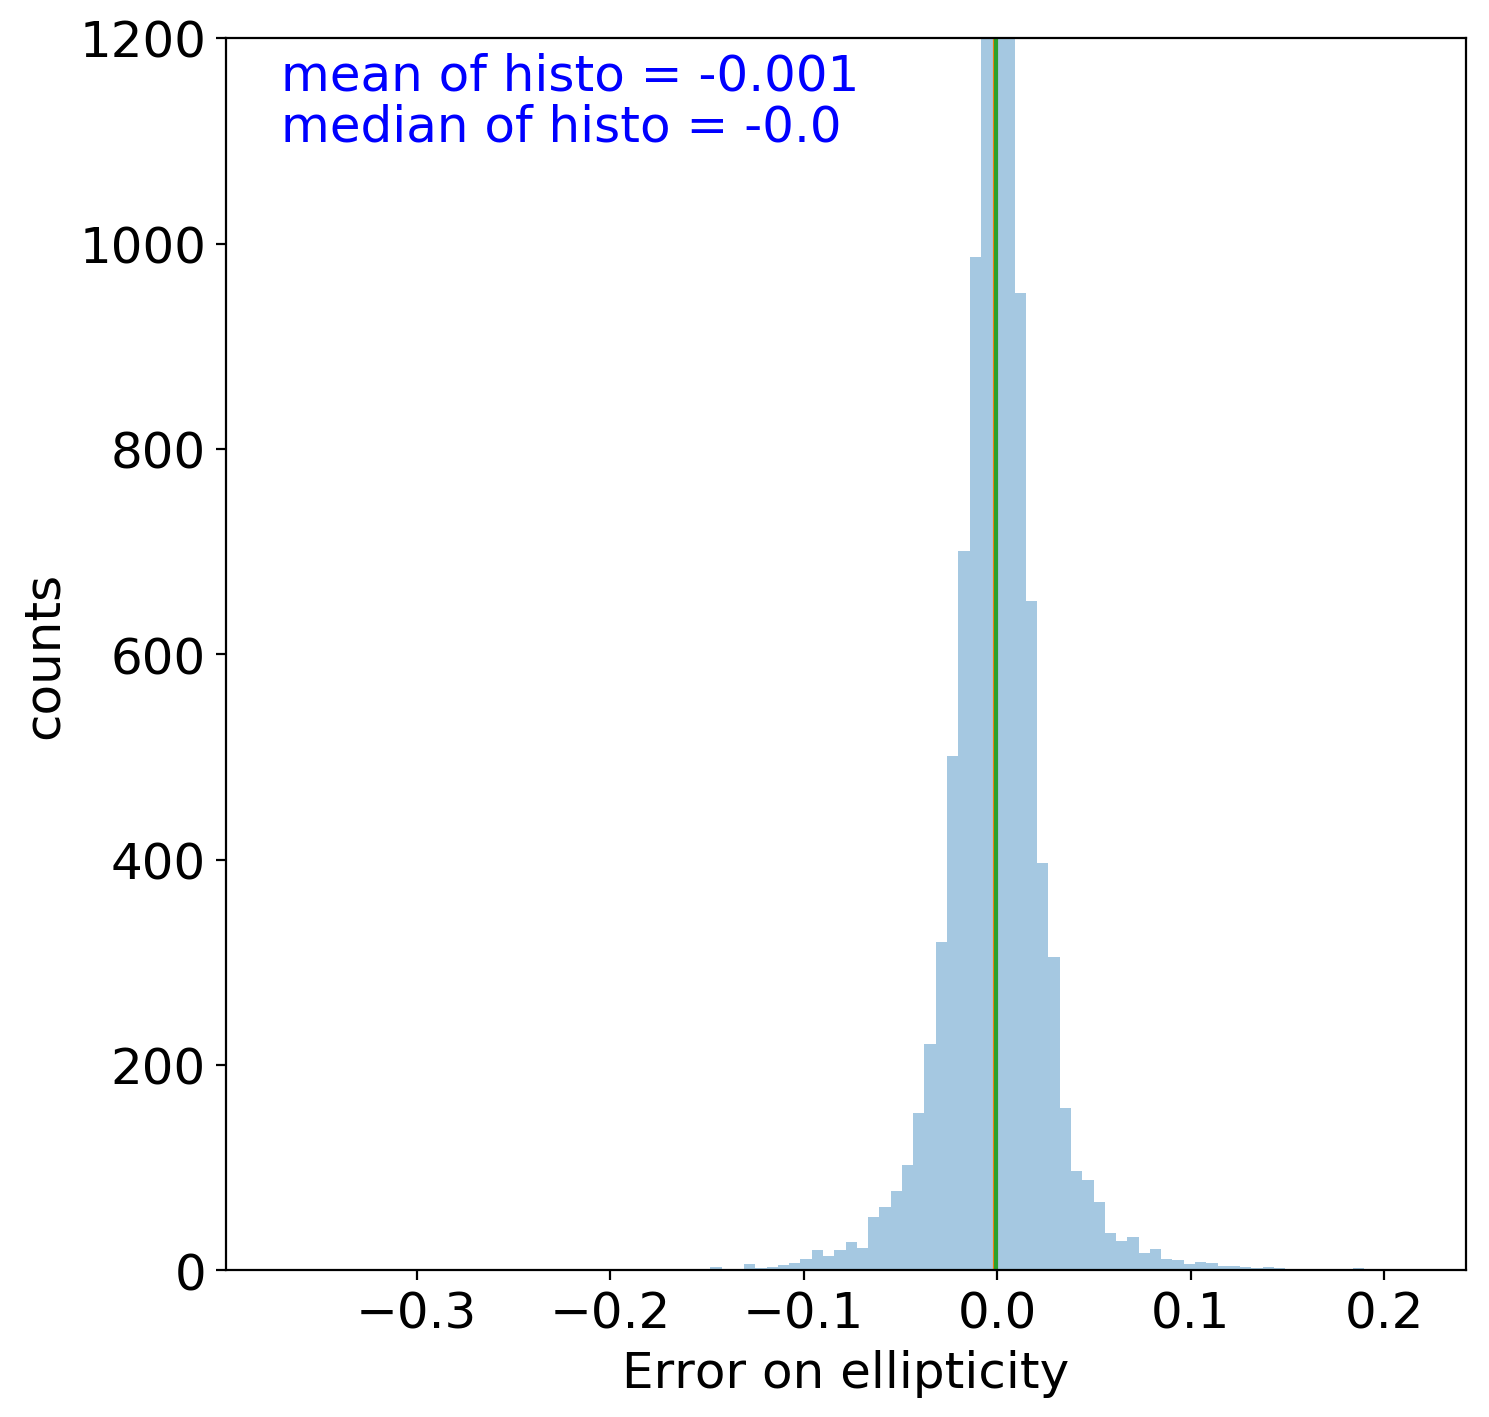

In [32]:
fig, axes = plt.subplots(1,1, figsize=(8,8))

a = sns.distplot(delta_e_lsst_euclid, bins = 100, hist = True, kde = False)
a.set_xlabel('Error on ellipticity')
a.set_ylabel('counts')
a.plot(np.ones((50,))*np.mean(delta_e_lsst_euclid),np.linspace(0, 1500))
a.plot(np.ones((50,))*np.median(delta_e_lsst_euclid),np.linspace(0, 1500))

a.set_ylim(0, 1200)
a.text(-0.37, 1150, 'mean of histo = '+str(round(np.mean(delta_e_lsst_euclid), 3)), color='b')
a.text(-0.37, 1100, 'median of histo = '+str(round(np.median(delta_e_lsst_euclid), 3)), color='b')

## Flux reproduction

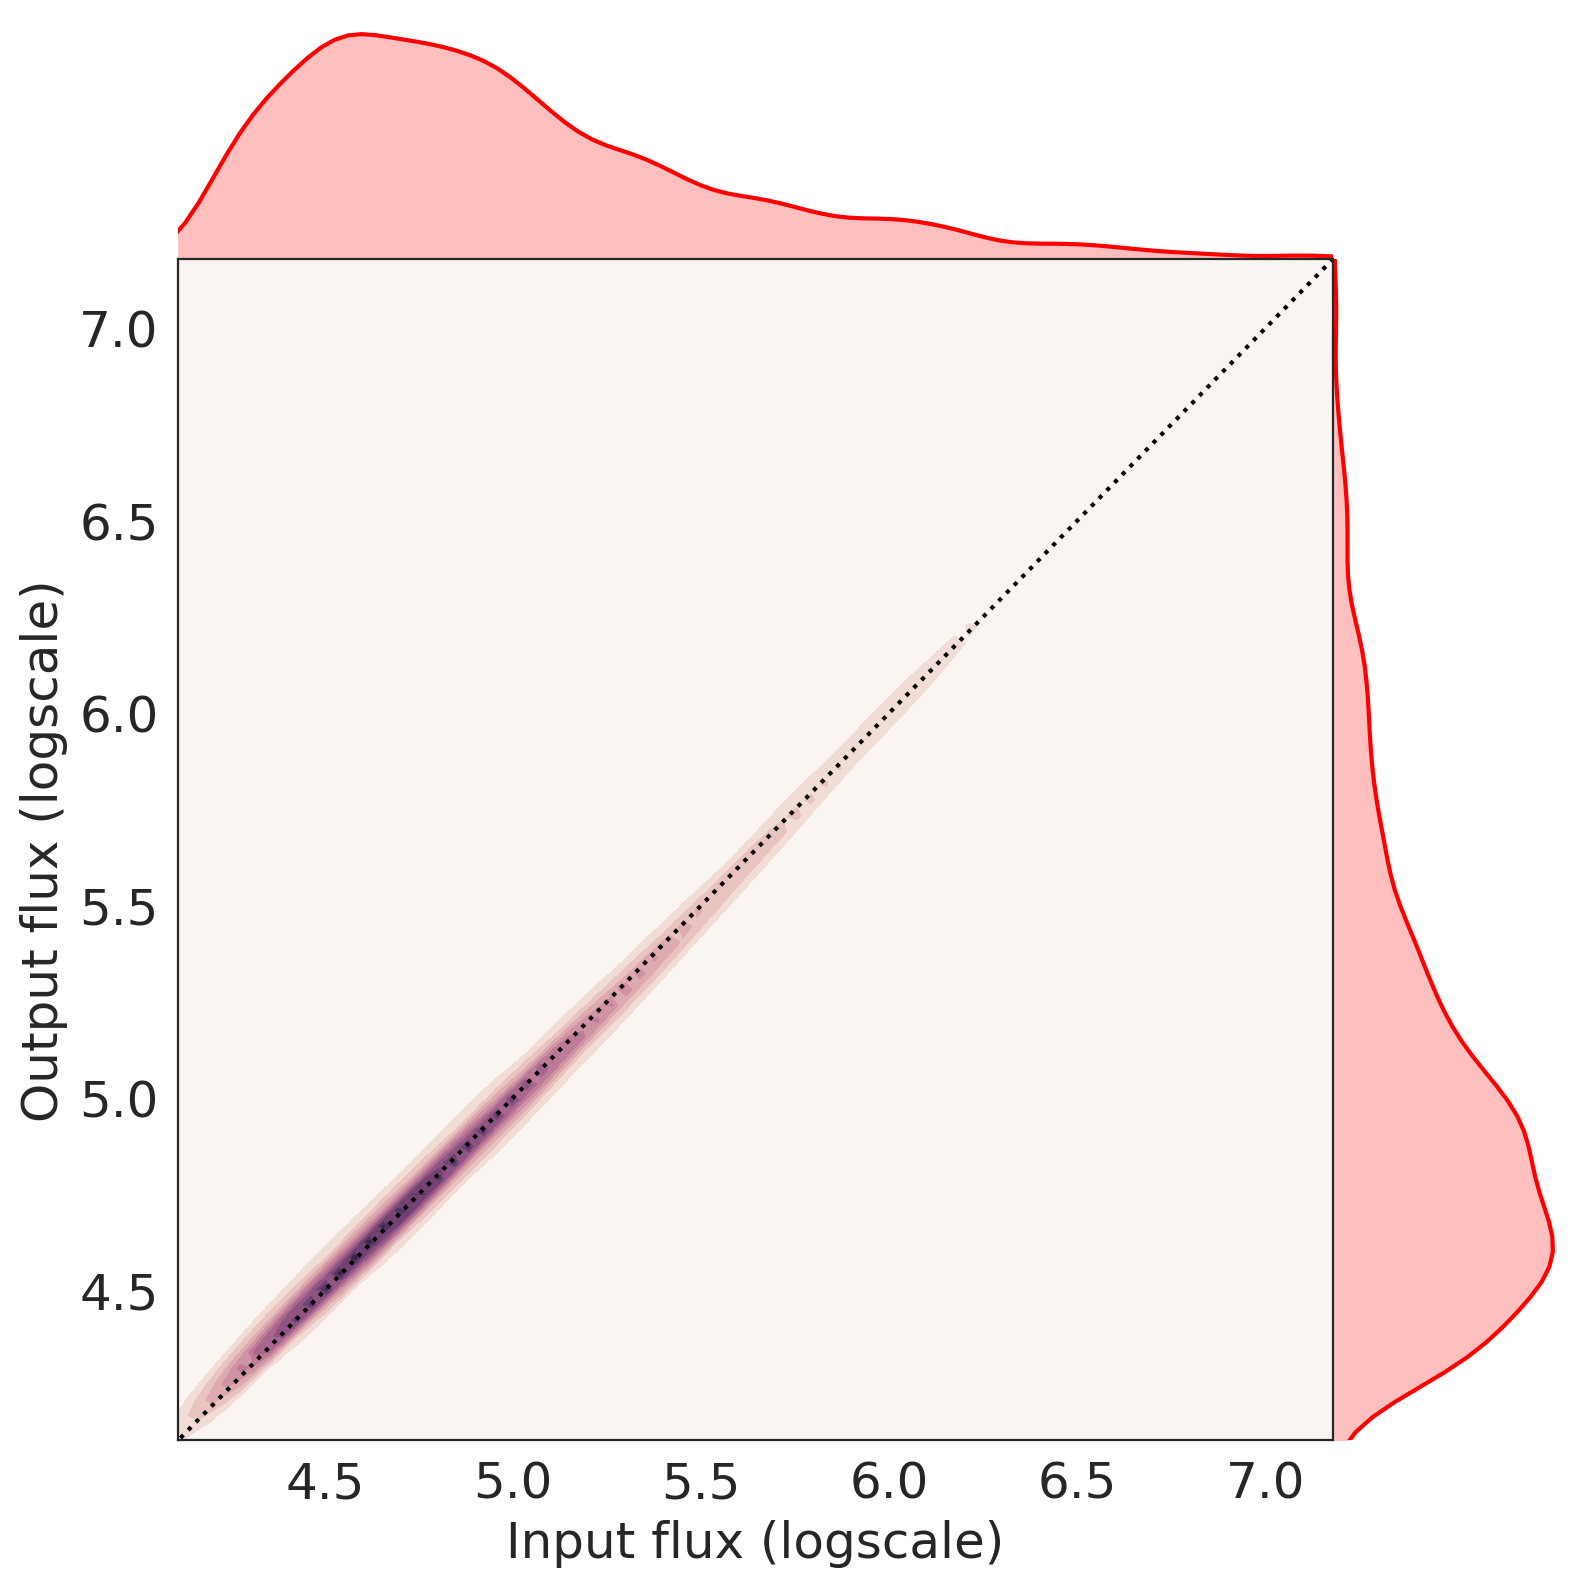

In [33]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

with sns.axes_style('white'):
            g = sns.jointplot(np.log10(flux_in_lsst_euclid), np.log10(flux_out_lsst_euclid), kind='kde',height =8,
                              xlim =[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))], ylim=[np.min(np.log10(flux_in_lsst_euclid-1000)), np.max(np.log10(flux_in_lsst_euclid))],cmap=cmap,color = 'red', space=0).set_axis_labels('Input flux (logscale)', 'Output flux (logscale)')
            #g.ax_joint.set_xscale('log')#color = sns.xkcd_rgb["dark green"],
            #g.ax_joint.set_yscale('log')
            g.ax_joint.plot(np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))),
                            np.linspace(-1, np.max(np.log10(flux_in_lsst_euclid))), ':k')

# Delta WL parameters

## As function of SNR

In [34]:
def boxplot(v,p,indices_lsst, indices_lsst_euclid, 
            xlim, ylim, 
            x_scale, 
            x_label, y_label,
            error_lsst_indices, error_lsst_euclid_indices,
            nbins = 11,
            legend_remove = False):
    matplotlib.rcdefaults()
    
    param_lsst = np.array(df[p][indices_lsst])
    param_lsst_euclid = np.array(df[p][indices_lsst_euclid])
    
    param_lsst_new = np.delete(param_lsst, error_lsst_indices)
    param_lsst_euclid_new = np.delete(param_lsst_euclid, error_lsst_euclid_indices)
    
    params = [param_lsst_new, param_lsst_euclid_new]
    
    #params = [np.array(df[p])]*3
    
    for i in range (len(v)):
        p_is_nan = np.where(np.isnan(params[i]))[0]
        v[i] = np.delete(v[i], p_is_nan)
        if i == 0:
            param_lsst_new = np.delete(np.array(params[i]), p_is_nan)
        else:
            param_lsst_euclid_new = np.delete(np.array(params[i]), p_is_nan)
    
    p_is_nan = np.where(np.isnan(df[p]))[0]
    new_p = np.delete(np.array(df[p]), p_is_nan)
    new_p = np.delete(new_p, np.random.choice(len(new_p), size = len(error_lsst_indices)+len(error_lsst_euclid_indices)))
    
    if x_scale == 'log':
        bins = np.geomspace(xlim[0], xlim[1], nbins)
    else :
        bins = np.linspace(xlim[0], xlim[1], nbins)
    
    bins[0] -= 1e-5
    bins[-1] += 1e-5
    param_bins = np.digitize(np.concatenate([param_lsst_new,param_lsst_euclid_new]), bins)
    
    v_conc = np.concatenate([v[0], v[1]])
    exp = ['LSST $ugrizy$']*len(param_lsst_new) + ['LSST+Euclid']*len(param_lsst_euclid_new)
    d = {'param':param_bins,'v_error':v_conc, 'exp':exp}

    fig, axes = plt.subplots(2,1, figsize=(4,3), gridspec_kw={'height_ratios': [1, 3]})
    fig.tight_layout()
    fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)
    
    if x_scale == 'log':
        sns.distplot(np.log10(new_p), ax = axes[0], hist = False, color = 'grey')
        axes[0].set_xlim(np.log10(bins[0]), np.log10(bins[-1]))
    else :
        sns.distplot(new_p, ax = axes[0], hist = False, color = 'grey')
        axes[0].set_xlim(bins[0], bins[-1])
    
    axes[0].set_yticks([])
    axes[0].set_xticks([])  
    axes[0].spines['right'].set_color('none')
    axes[0].spines['top'].set_color('none')
    axes[0].spines['left'].set_color('none')


    pal = ["#3498db","#e74c3c"]
    axes[1] = sns.boxplot(x="param", y="v_error",hue='exp', data=d, fliersize = 0., palette = sns.color_palette(pal))
    #axes[1] = sns.violinplot(x="param", y="v_error",hue='exp', data=d, split = True, fliersize = 0., palette = sns.color_palette(pal))
    axes[1].axhline(0, c ='0.8', ls = '-', lw=1, zorder = -3)

    axes[1].set_ylabel(y_label)
    axes[1].set_xticks([])
    axes[1].legend(fontsize = 9, frameon = False, loc ='upper right', borderpad = 0.1)
    if legend_remove :
        axes[1].legend_.remove()
    axes[1].set_ylim(ylim)

    ax = axes[1].twiny()
    ax.set_xlim(bins[0], bins[-1])
    if x_scale == 'log':
        ax.set_xscale('log')
    ax.xaxis.tick_bottom()
    ax.set_xlabel(x_label)
    ax.xaxis.set_label_position('bottom')

### Error on ellipticity

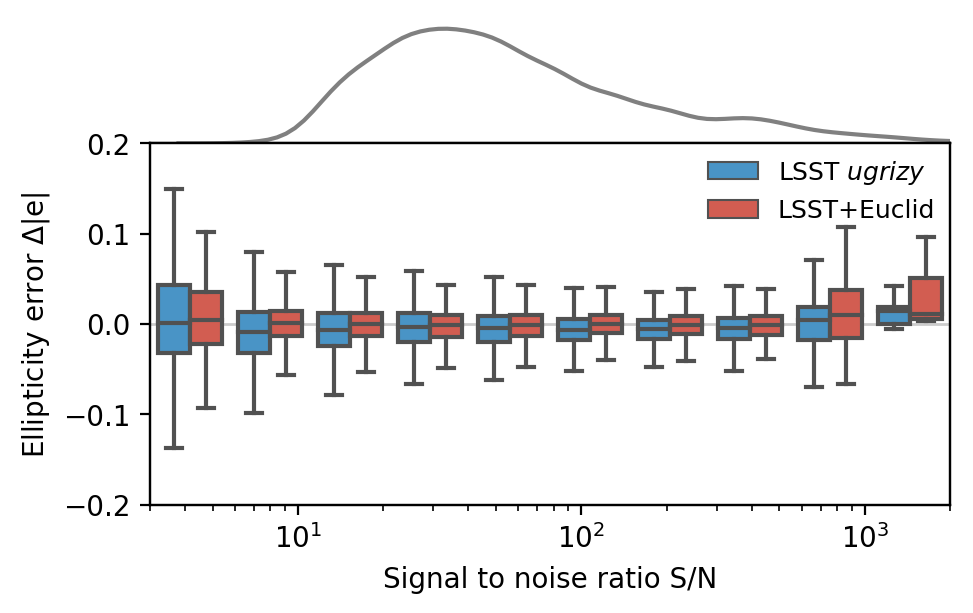

In [36]:
boxplot([delta_e_lsst, delta_e_lsst_euclid],'SNR',
         indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (3.01, 2000),ylim = (-0.2, 0.2), x_scale = 'log',
         x_label='Signal to noise ratio S/N', y_label = 'Ellipticity error $\Delta$|e|',
        error_lsst_indices = [], error_lsst_euclid_indices = [7146],
        legend_remove = False)
#plt.savefig('figures/e_snr.pdf')

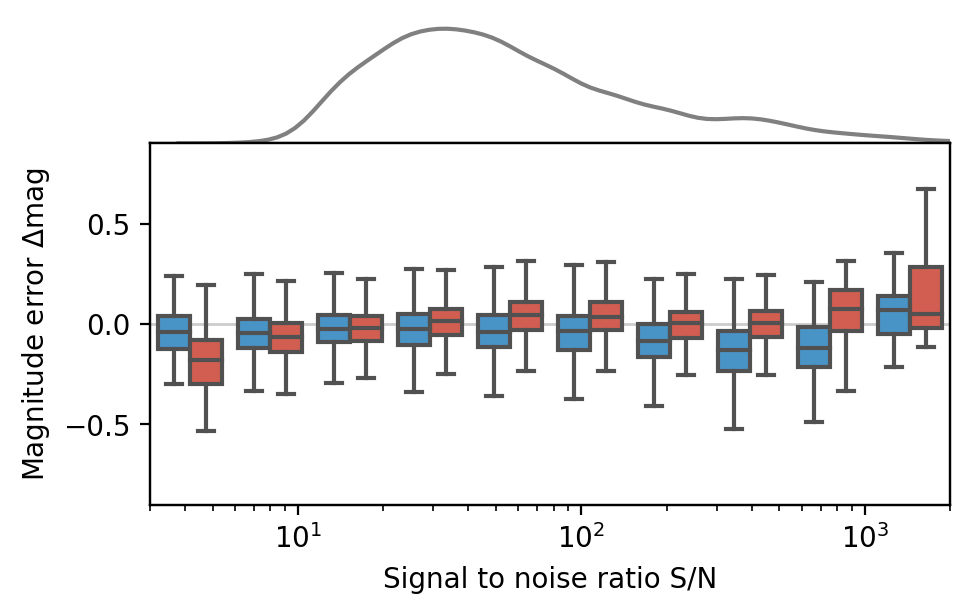

In [37]:
boxplot([delta_mag_lsst, delta_mag_lsst_euclid],'SNR',
         indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (3.01, 2000),ylim = (-0.9,0.9), x_scale = 'log',
         x_label='Signal to noise ratio S/N', y_label = 'Magnitude error $\Delta$mag',
         error_lsst_indices = [], error_lsst_euclid_indices = [7146],
         legend_remove = True)
#plt.savefig('figures/mag_snr.pdf')

### Error on flux

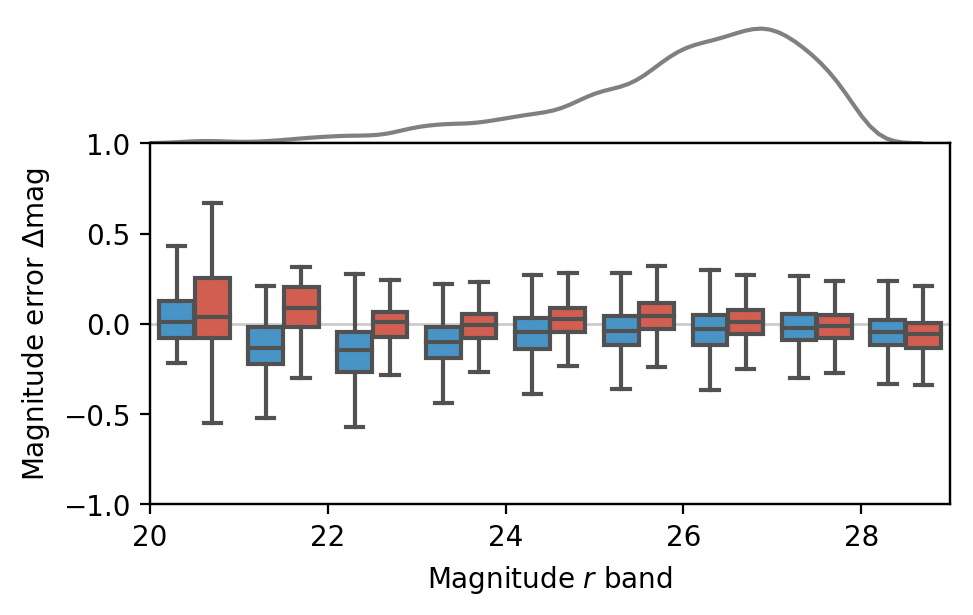

In [38]:
boxplot([delta_mag_lsst, delta_mag_lsst_euclid],'mag',
         indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (20., 29.),ylim = (-1.,1.), x_scale = None,
         x_label='Magnitude $r$ band', y_label = 'Magnitude error $\Delta$mag',
         error_lsst_indices = [], error_lsst_euclid_indices = [7146],
         legend_remove = True)
plt.savefig('figures/mag_mag.pdf')

## As a function of blend rate

### As a function of blend rate with closest

#### Error on ellipticity

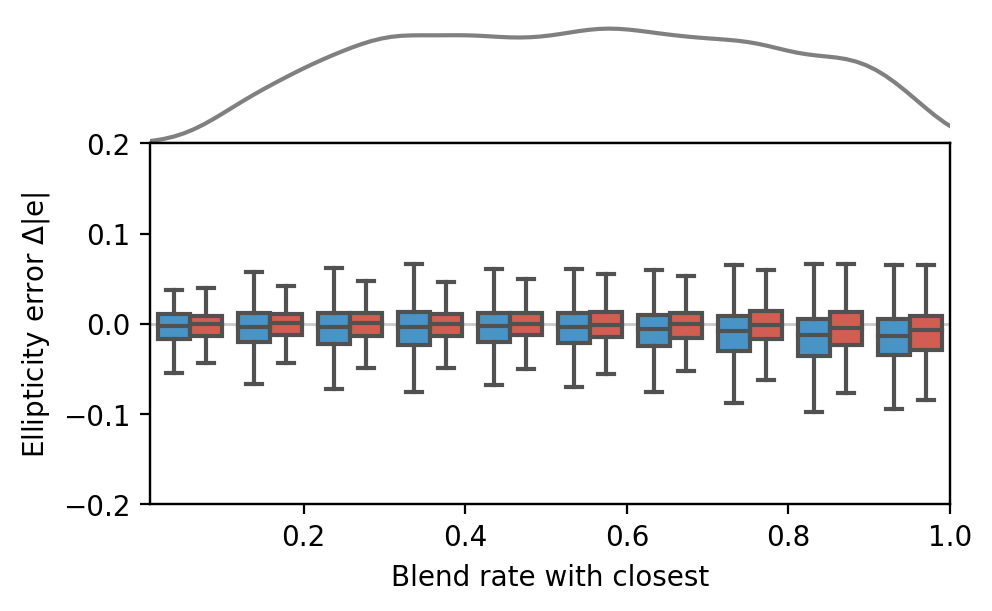

In [43]:
boxplot([delta_e_lsst, delta_e_lsst_euclid],'blendedness_closest_lsst',
        indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.01, 1.),ylim = (-0.2,0.2), x_scale = None,
         x_label='Blend rate with closest', y_label = 'Ellipticity error $\Delta$|e|',
         error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
         legend_remove = True)
plt.savefig('figures/e_b_c.pdf')

#### Error on flux

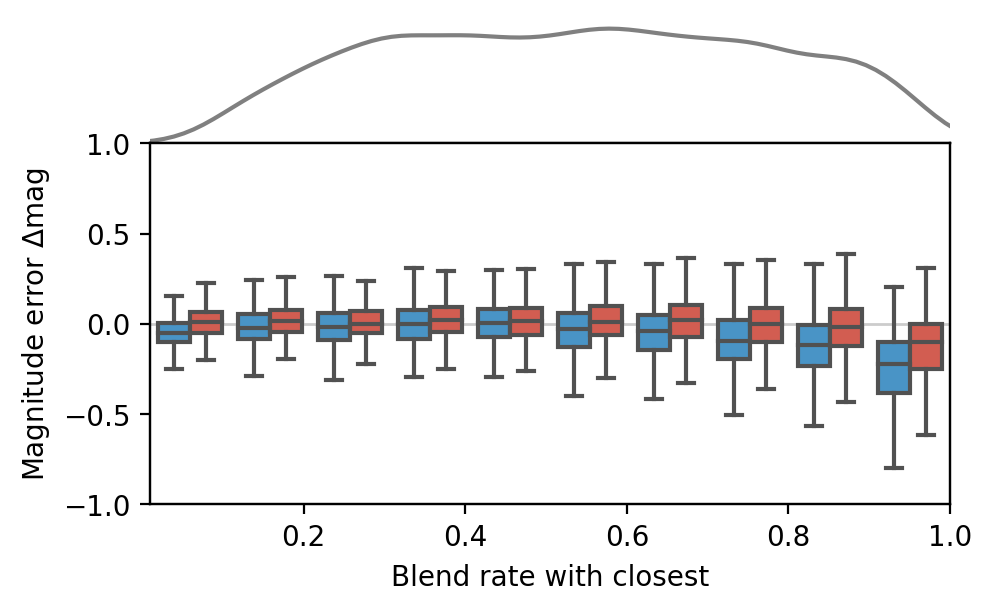

In [44]:
boxplot([delta_mag_lsst, delta_mag_lsst_euclid],'blendedness_closest_lsst',
        indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.01, 1.),ylim = (-1.,1.), x_scale = None,
         x_label='Blend rate with closest', y_label = 'Magnitude error $\Delta$mag',
        error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
        legend_remove = True)
plt.savefig('figures/mag_b_c.pdf')

### As a function of total blend rate

#### Error on ellipticity

In [91]:
np.max(df['blendedness_total_lsst'])

0.764361172914505

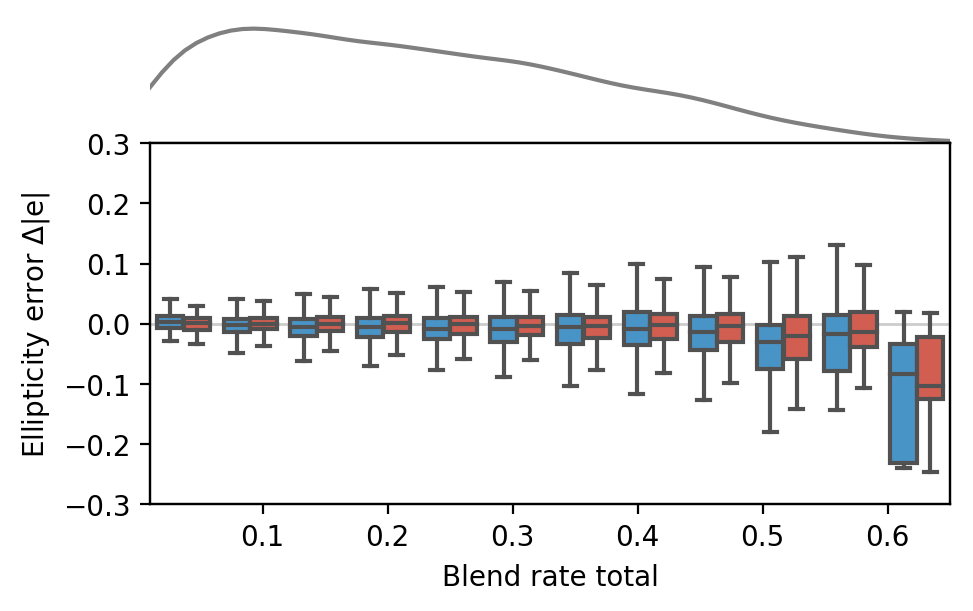

In [45]:
boxplot([delta_e_lsst, delta_e_lsst_euclid],'blendedness_total_lsst',
        indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.01, 0.65),ylim = (-0.3,0.3), x_scale = None,
         x_label='Blend rate total', y_label = 'Ellipticity error $\Delta$|e|',
         error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
         legend_remove = True)
plt.savefig('figures/e_b_tot.pdf')

#### Error on flux

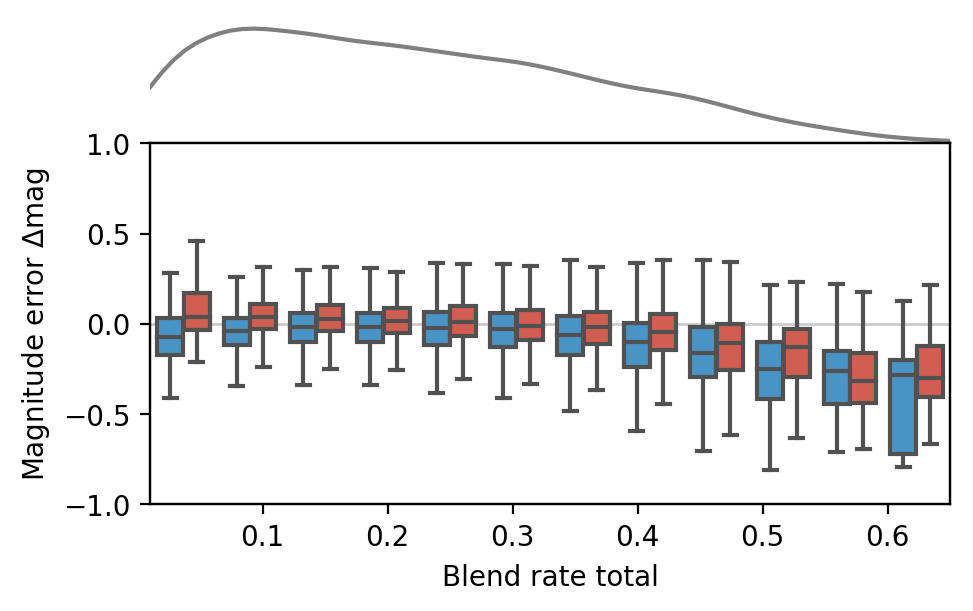

In [46]:
boxplot([delta_mag_lsst, delta_mag_lsst_euclid],'blendedness_total_lsst',
        indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.01, 0.65),ylim = (-1.,1.), x_scale = None,
         x_label='Blend rate total', y_label = 'Magnitude error $\Delta$mag',
         error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
         legend_remove = True)
plt.savefig('figures/mag_b_tot.pdf')

## As a function of aperture blending fraction

### Error on ellipticity

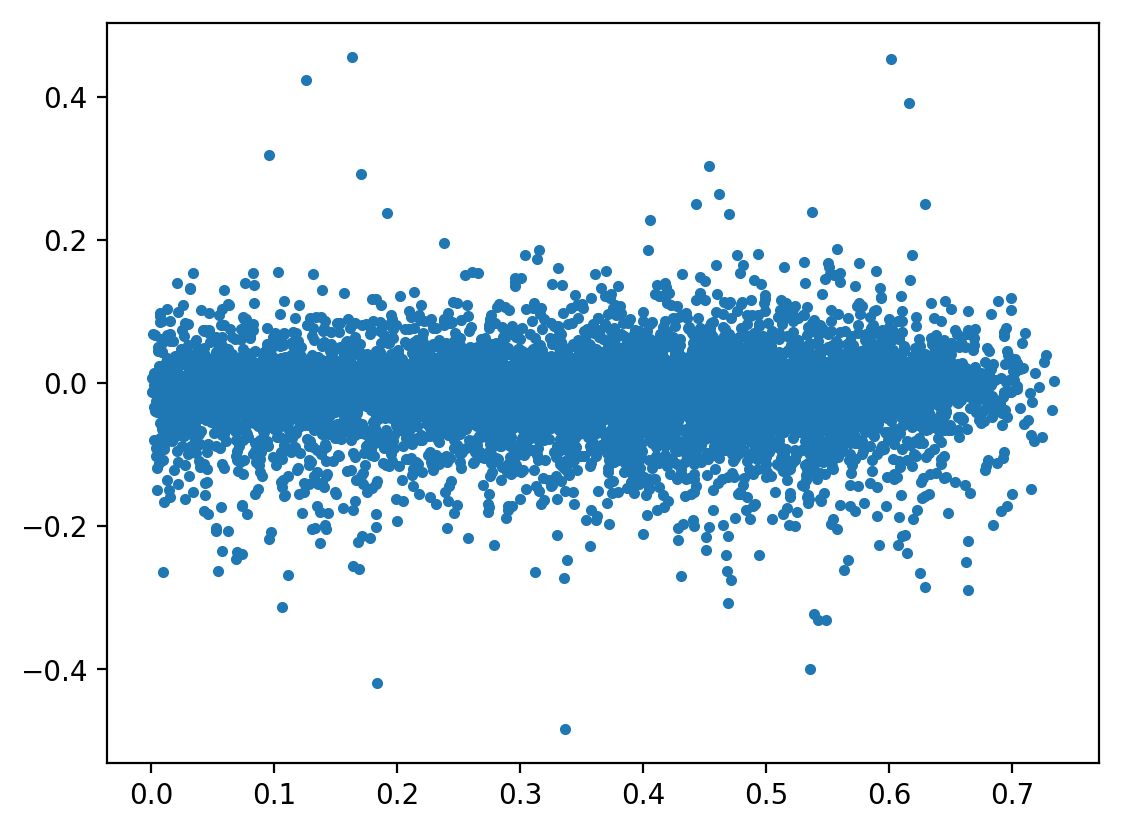

In [183]:
plt.plot(df['blendedness_aperture_lsst'],delta_e_lsst, '.')

In [150]:
np.max(df['blendedness_aperture_lsst'])

0.7633289094576846

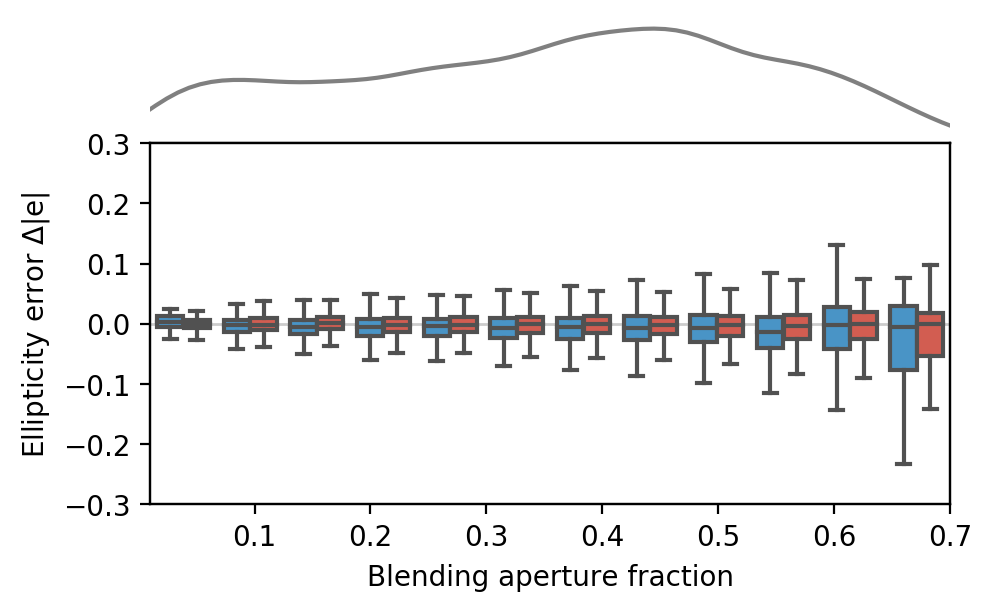

In [47]:
boxplot([delta_e_lsst, delta_e_lsst_euclid],'blendedness_aperture_lsst',
         indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.01, 0.7),ylim = (-0.3,0.3), x_scale = None,
         x_label='Blending aperture fraction', y_label = 'Ellipticity error $\Delta$|e|',
         error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
         legend_remove = True)
plt.savefig('figures/e_b_apt.pdf')

### Error on magnitude

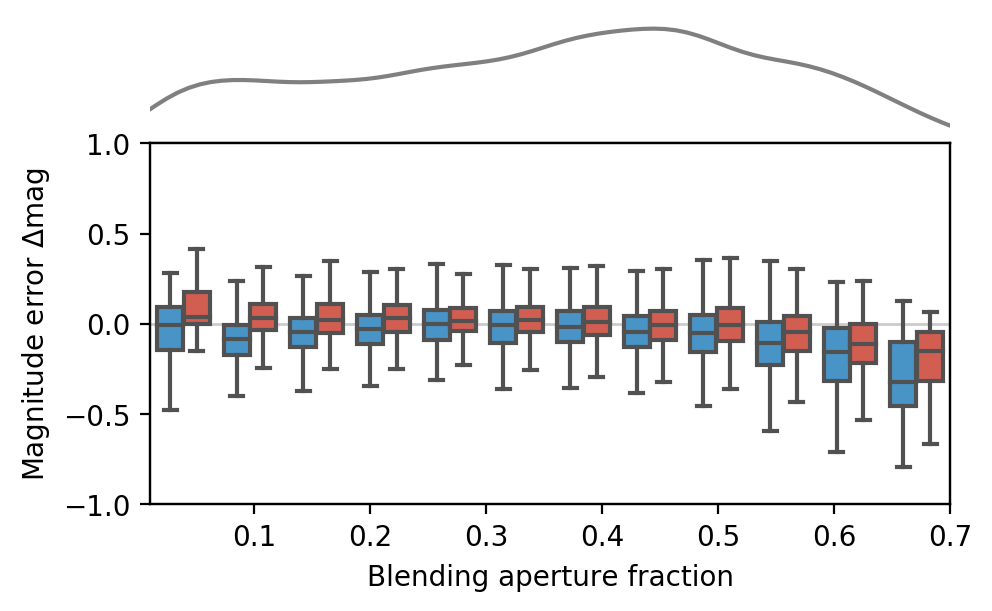

In [48]:
boxplot([delta_mag_lsst, delta_mag_lsst_euclid],'blendedness_aperture_lsst',
         indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.01, 0.7),ylim = (-1.,1.), x_scale = None,
         x_label='Blending aperture fraction', y_label = 'Magnitude error $\Delta$mag',
         error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
         legend_remove = True)
plt.savefig('figures/mag_b_apt.pdf')

## As a function of delta magnitude

### Error on ellipticity

In [50]:
df['delta_mag_closest'] =  df['closest_mag'] - df['mag']

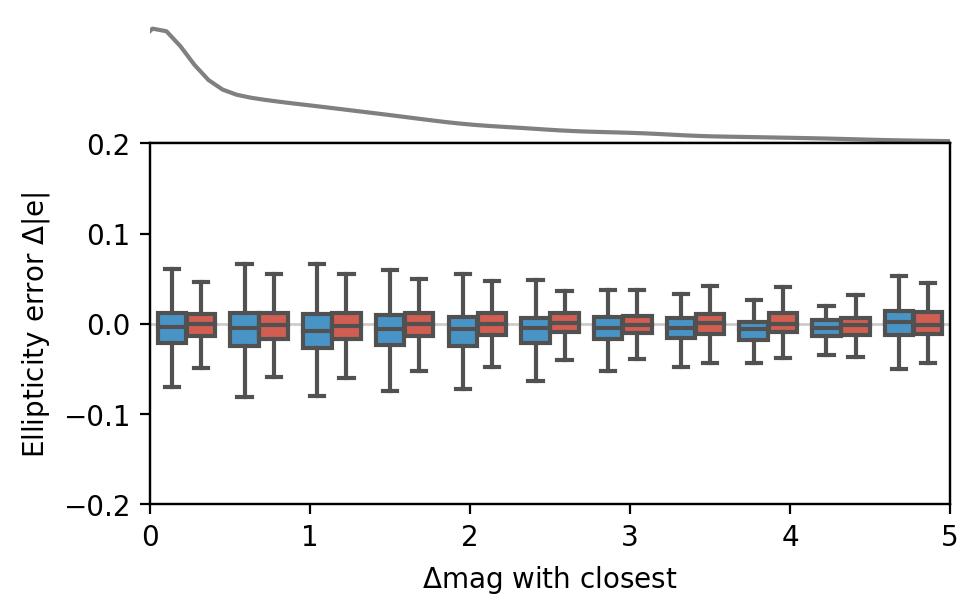

In [53]:
boxplot([delta_e_lsst, delta_e_lsst_euclid],'delta_mag_closest',
        indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.0, 5.),ylim = (-0.2,0.2), x_scale = None,
         x_label='$\Delta$mag with closest', y_label = 'Ellipticity error $\Delta$|e|',
       error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
       legend_remove = True)
plt.savefig('figures/e_mag_c.pdf')

### Error on flux

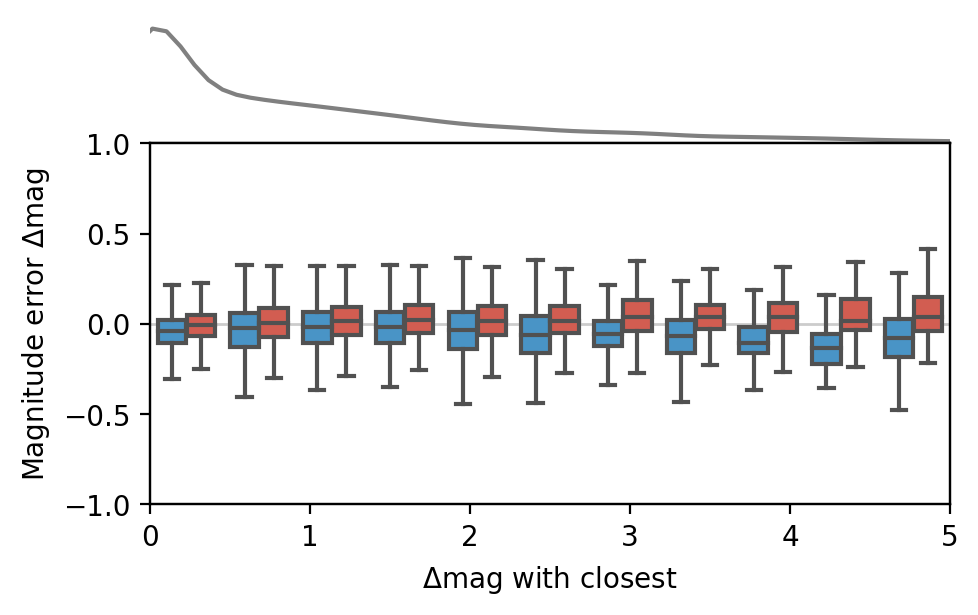

In [52]:
boxplot([delta_mag_lsst, delta_mag_lsst_euclid],'delta_mag_closest',
        indices_lsst = indices_lsst, indices_lsst_euclid = indices_lsst_euclid,
         xlim = (0.0, 5.),ylim = (-1.,1.), x_scale = None,
         x_label='$\Delta$mag with closest', y_label = 'Magnitude error $\Delta$mag',
       error_lsst_indices = [], error_lsst_euclid_indices = [2159, 8626],
       legend_remove = True)
plt.savefig('figures/mag_mag_c.pdf')

# N sampling for the same galaxy on few blended images

In [18]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [19]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [22]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [23]:
list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [20]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

flux_out_lsst = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
flux_out_lsst_euclid = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
input_noisy = []
output_deblender = []
output_deblender_lsst_euclid = []
blend_rate = []
nb_of_gal = []
err_count = 0

# Measurement of fluxes
mask = plot.createCircularMask(stamp_size,stamp_size,None,5)


for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst_euclid, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = deblender_lsst.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)
        
        output_vae_list_lsst_euclid = deblender_lsst_euclid.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst_euclid = denorm (output_vae_list_lsst_euclid, bands_lsst_euclid, channel_last = True)
        
        if j == (nb_of_samplings-1) :  
            input_noisy.append(denorm(list_galsim_simple[0], bands_lsst_euclid, channel_last = True))
            output_deblender.append(output_vae_list_lsst)
            output_deblender_lsst_euclid.append(output_vae_list_lsst_euclid)
            blend_rate.append(list_galsim_simple[7][0])
            nb_of_gal.append(len(list_galsim_simple[5]))

        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst[t,:,:,2].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst[i,j*batch_size+t] = np.sum(masked_img_in_simple)

            img_out_simple_euclid = galsim.Image(output_vae_list_lsst_euclid[t][:,:,6])
            res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e1
            res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e2
            res_out_lsst_euclid_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple_euclid,final_epsf_image).observed_shape.e   
            masked_img_in_simple = output_vae_list_lsst_euclid[t,:,:,6].copy()
            masked_img_in_simple[~mask] = 0  
            flux_out_lsst_euclid[i,j*batch_size+t] = np.sum(masked_img_in_simple)

    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')
flux_in = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    masked_img_in_simple = input_noiseless[k][0][:,:,6].copy()
    masked_img_in_simple[~mask] = 0  
    flux_in[k] = np.sum(masked_img_in_simple)

    print(res_in_e1[k], res_in_e2[k])

0.0015546844 0.0059353914
0.24678348 0.26398543
-0.22094715 0.34989557


[]

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


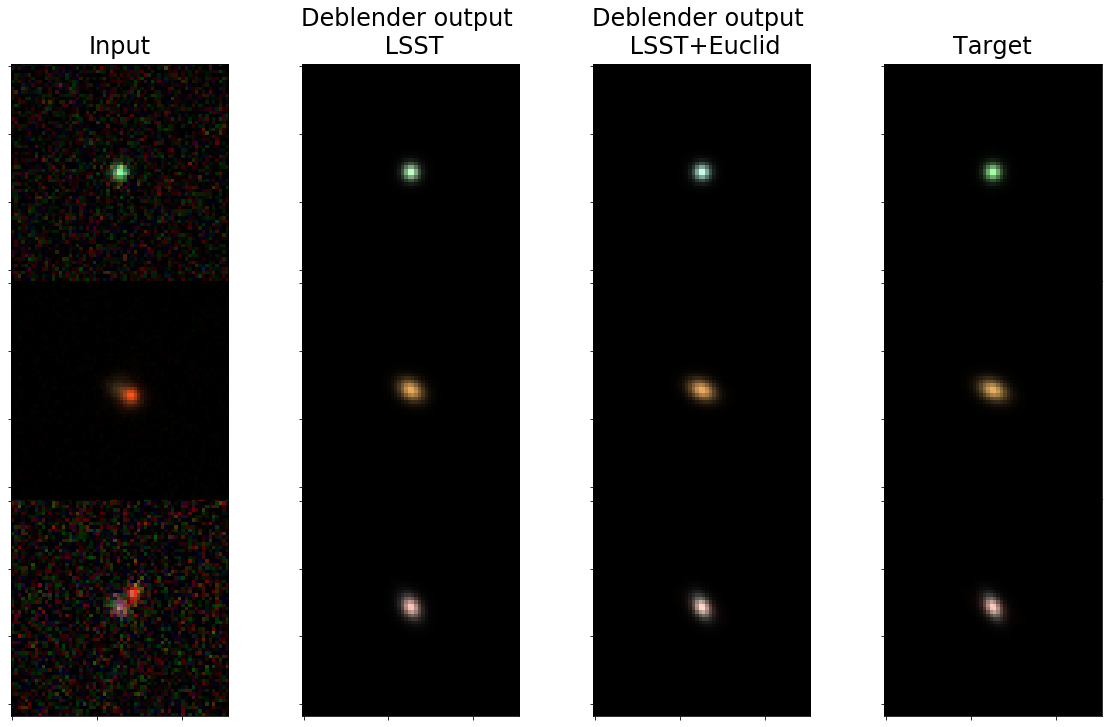

In [35]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))



####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Input', pad = 10)

ax = axes[0,1]
plot_rgb_lsst(np.mean(output_deblender[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST', pad = 10)

ax = axes[0,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[0], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Deblender output \n LSST+Euclid', pad = 10)

ax = axes[0,3]
plot_rgb_lsst_euclid(input_noiseless[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('Target', pad = 10)


####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
plot_rgb_lsst(np.mean(output_deblender[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[1], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,3]
plot_rgb_lsst_euclid(input_noiseless[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
plot_rgb_lsst(np.mean(output_deblender[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,2]
plot_rgb_lsst_euclid(np.mean(output_deblender_lsst_euclid[2], axis = 0),stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,3]
plot_rgb_lsst_euclid(input_noiseless[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

In [36]:
blend_rate

[array([], dtype=float64),
 array([0.53614187, 0.27017361, 0.28062558]),
 array([0.10091618])]

0.16652507 0.3


Text(0.5, 0, 'total flux in - total flux out / \n total flux in')

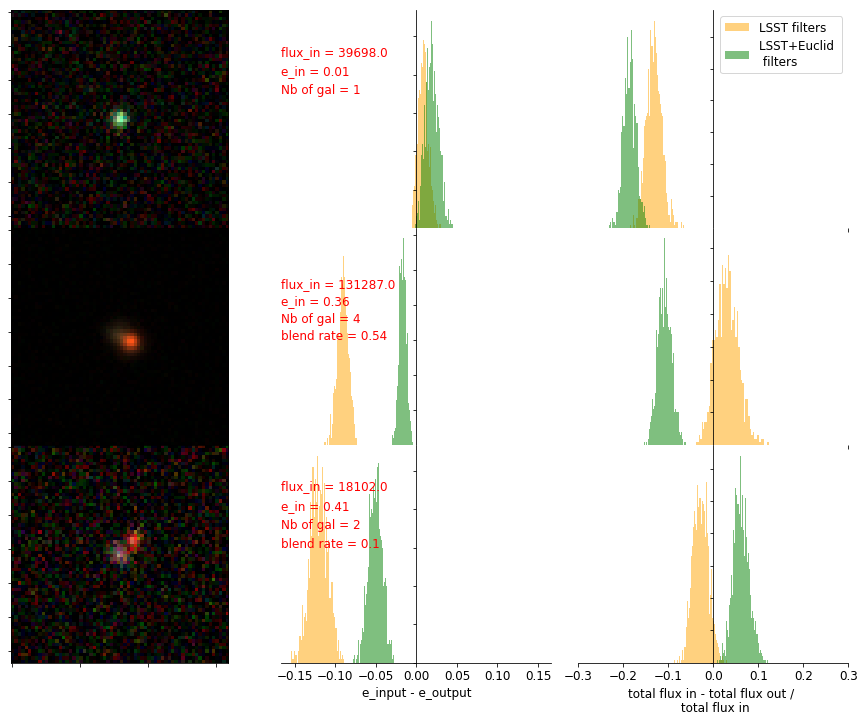

In [37]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(right=1, left=0,hspace=0,wspace=0.1)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))

max_x = np.max(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
min_x = np.min(((flux_out_lsst[0]- flux_in[0])/flux_in[0], (flux_out_lsst[1]- flux_in[2])/flux_in[1], (flux_out_lsst[2]- flux_in[2])/flux_in[2]))
max_lim_flux = 0.3# np.max((np.abs(max_x), np.abs(min_x)))

print(max_lim, max_lim_flux)
####### Galaxy 1
ax = axes[0,0]
plot_rgb_lsst_euclid(input_noisy[0][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('Input', pad = 10)

ax = axes[0,1]
ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[0]- res_in_e[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[0], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[0], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[0])+1, 0)), fontsize =12, color='r')
if len(blend_rate[0])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[0]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)

ax = axes[0,2]
ax.hist((flux_out_lsst[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[0]- flux_in[0])/flux_in[0], bins = 50, label ='LSST+Euclid \n filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_title('0utput measured \n ellipticity distribution', pad = 10)



####### Galaxy 2
ax = axes[1,0]
plot_rgb_lsst_euclid(input_noisy[1][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[1]- res_in_e[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color ='green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[1], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[1], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[1])+1, 0)), fontsize =12, color='r')
if len(blend_rate[1])!=0:
    ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[1]), 2)), fontsize =12, color='r')

ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,2]
ax.hist((flux_out_lsst[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[1]- flux_in[1])/flux_in[1], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlabel('e')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])
ax.set_xticklabels([])


####### Galaxy 3
ax = axes[2,0]
plot_rgb_lsst_euclid(input_noisy[2][0],stamp_size, ax)
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist(res_out_lsst_euclid_e[2]- res_in_e[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
#ax.text(-max_lim, 50, 'SNR = '+str(round(SNR[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 45, 'flux_in = '+str(round(flux_in[2], 0)), fontsize =12, color='r')
ax.text(-max_lim, 40, 'e_in = '+str(round(res_in_e[2], 2)), fontsize =12, color='r')
ax.text(-max_lim, 35, 'Nb of gal = '+str(round(len(blend_rate[2])+1, 0)), fontsize =12, color='r')
if len(blend_rate[2])!=0:
       ax.text(-max_lim, 30, 'blend rate = '+str(round(np.max(blend_rate[2]), 2)), fontsize =12, color='r')

ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('e_input - e_output')


ax = axes[2,2]
ax.hist((flux_out_lsst[2]-flux_in[2])/flux_in[2] , bins = 50, label ='LSST \n filters' , alpha = 0.5, color = 'orange')
ax.hist((flux_out_lsst_euclid[2]- flux_in[2])/flux_in[2], bins = 50, label ='LSST+Euclid filters' , alpha = 0.5, color = 'green')
ax.set_xlim(-max_lim_flux, max_lim_flux)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])
ax.set_xlabel('total flux in - total flux out / \n total flux in')
